In [98]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

In [99]:
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


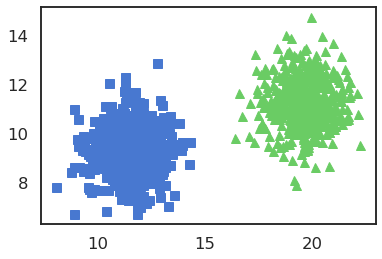

In [118]:
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=2, center_box=(0, 20))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [119]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [120]:
BATCH_SIZE = 32
n_features = 2
training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).float())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [121]:
len(testing_dataset)

200

# Define accuracy & Model

In [122]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(torch.flatten(output) - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(testing_dataset)
    
    return acc

In [132]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# The calculation for immediate sensitivity

In [124]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(outputs, labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

In [129]:
def plot_decision_boundary(X, y, model, loss, steps=1000, cmap='Paired', title=None):
    cmap = plt.get_cmap(cmap)
    #torch.abs(torch.flatten(output) - labels) < 0.5

    xmin, xmax = 0, 30
    ymin, ymax = 0, 20
    # Define region of interest by data limits
#     xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
#     ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    mesh_examples = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    labels = model.forward(mesh_examples) < 0.5

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape).detach().numpy()

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # get sensitivities of the data
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                  loss, 
                                                  torch.from_numpy(X).float(), 
                                                  torch.from_numpy(y).float(), 
                                                  None)
    
    # Get predicted labels on training data and plot
    train_labels = model.forward(torch.from_numpy(X).float())
    #ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)
    ax.scatter(X[:,0], X[:,1], s=5*(np.array(sensitivities)-10), c=sensitivities, cmap='binary', lw=0)

    if title != None:
        plt.title(title)
    
    return fig, ax

# Train the model, calculating immediate sensitivities

In [135]:
def run_experiment(epsilon):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 200
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 25
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []
    all_batch_mean_sensitivities = []
    all_batch_max_sensitivities = []

    for epoch in range(epochs):
#         print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.extend(batch_sensitivities)
            all_batch_mean_sensitivities.append(np.mean(batch_sensitivities) / BATCH_SIZE)
            all_batch_max_sensitivities.append(np.max(batch_sensitivities) / BATCH_SIZE)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

#             with torch.no_grad():
#                 for p in model.parameters():
#                     p.grad += (sigma * torch.randn(1).float())

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        mean_sensitivities.append(np.mean(all_sensitivities))
        max_sigmas.append(np.max(sigmas))        
        mean_sigmas.append(np.mean(sigmas))
        test_accs.append(accuracy(model, test_loader))
        
        plot_decision_boundary(X, y, model, nn.BCELoss(), steps=100, title=f'Epoch {epoch}')
        
#         print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
#         print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
#         print("Max sigma for the epoch:", max_sigmas[-1])
#         print("Mean sigma for the epoch:", mean_sigmas[-1])

#         print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, 
                                          mean_sigmas, test_accs,
                                          all_batch_mean_sensitivities, all_batch_max_sensitivities), model

/home/jnear/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Final accuracy: 0.96


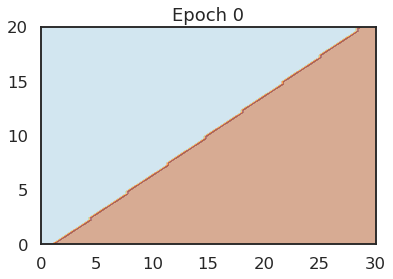

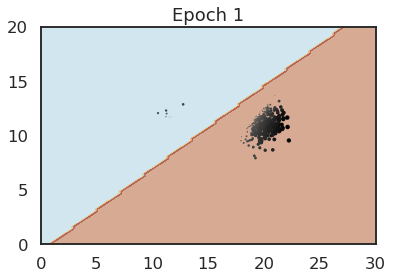

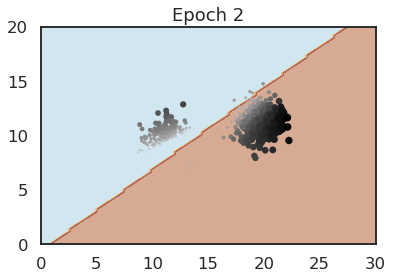

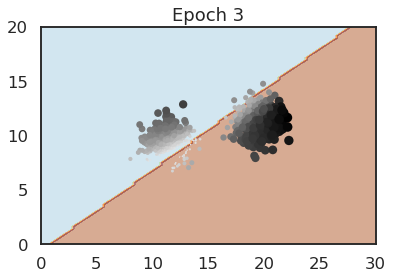

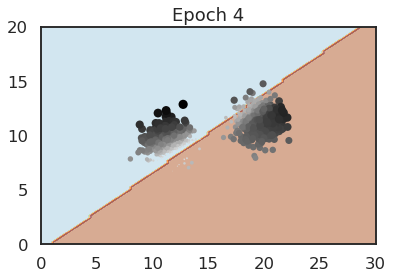

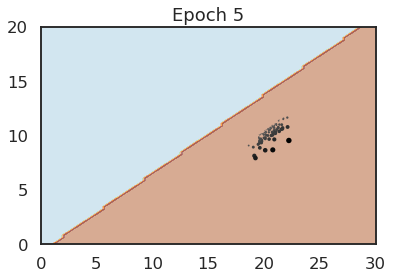

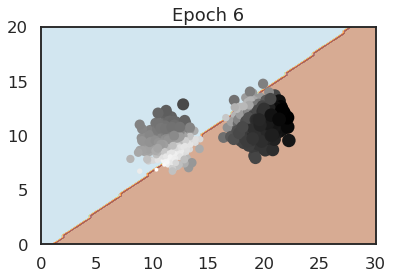

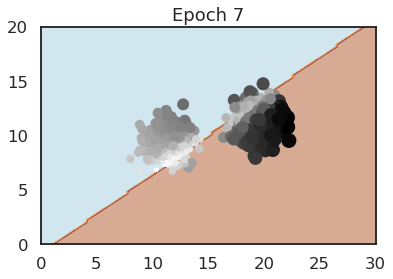

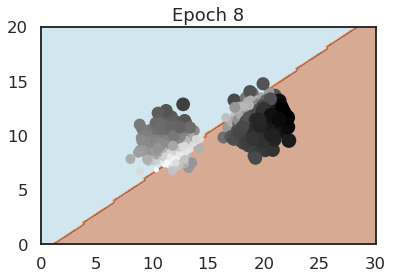

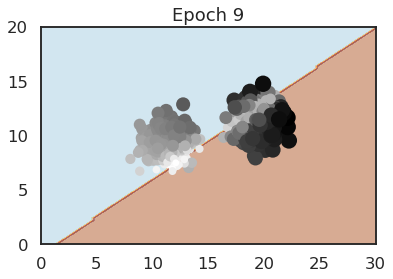

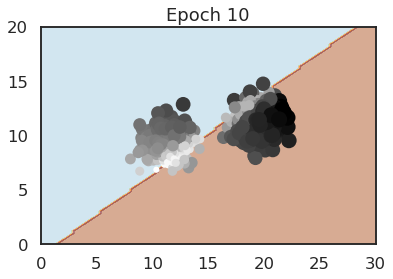

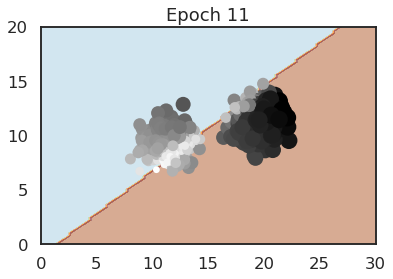

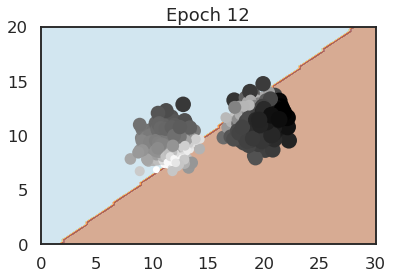

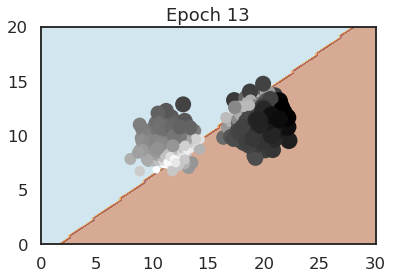

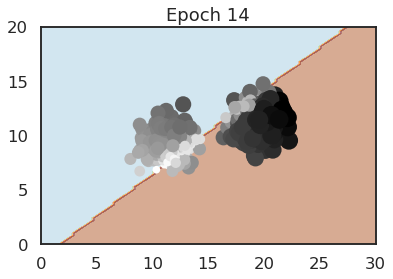

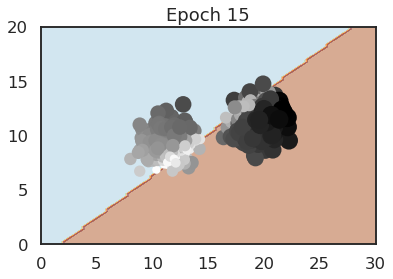

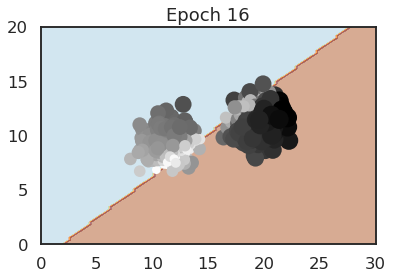

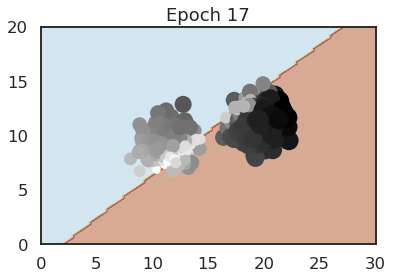

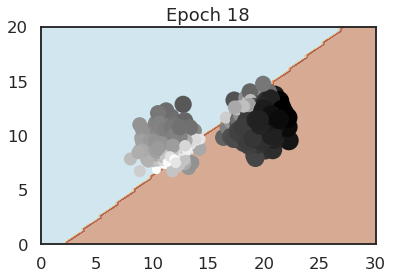

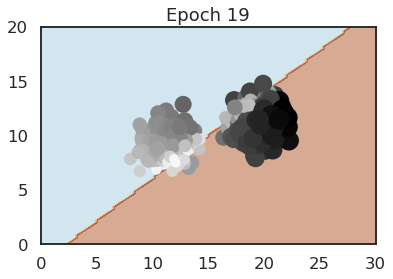

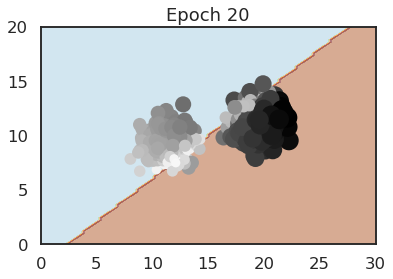

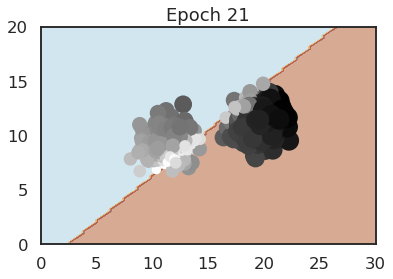

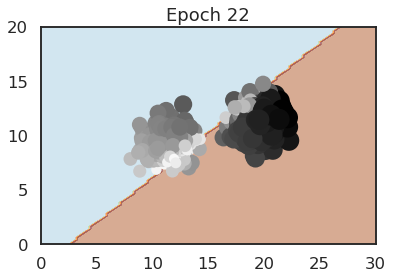

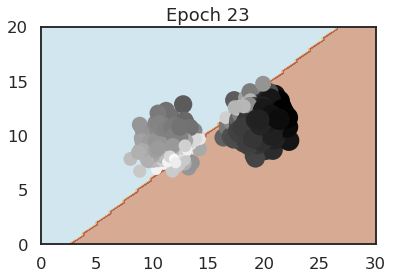

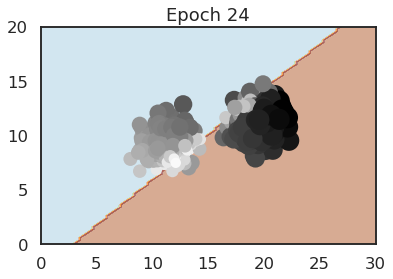

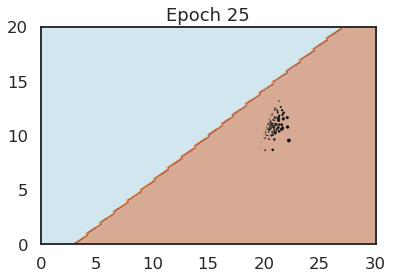

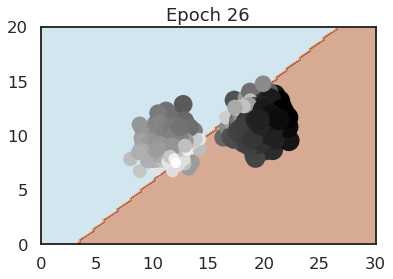

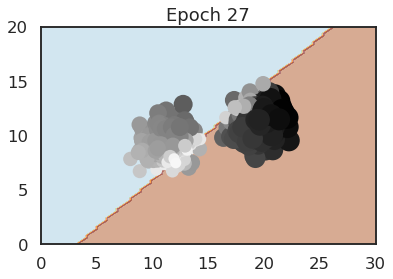

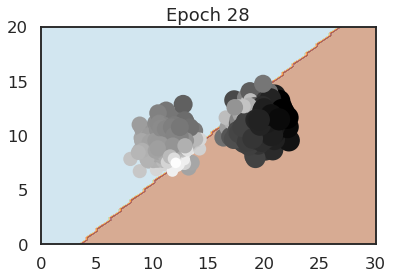

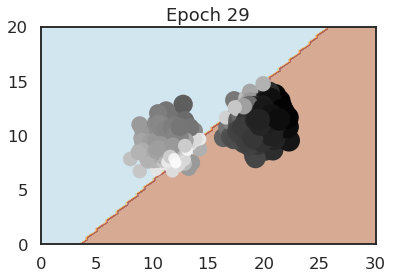

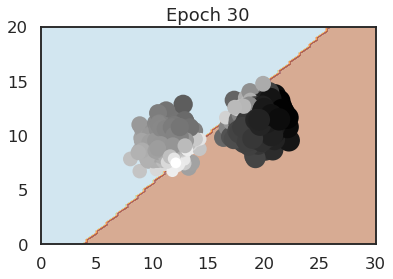

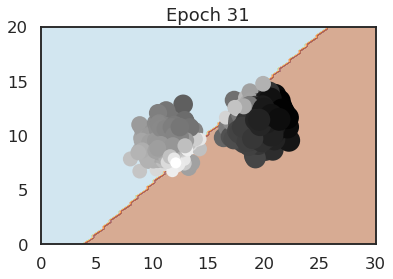

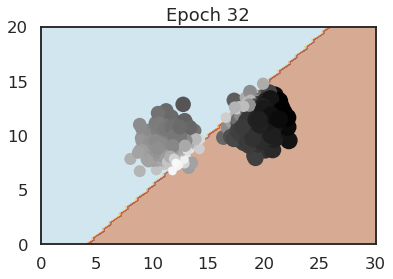

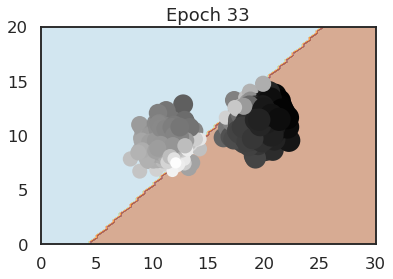

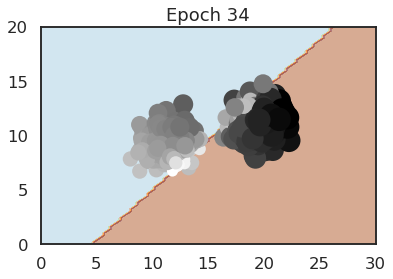

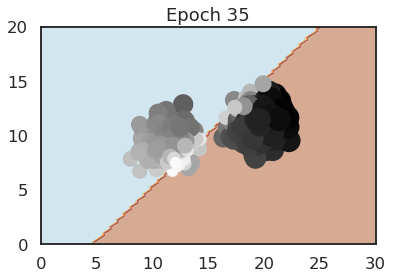

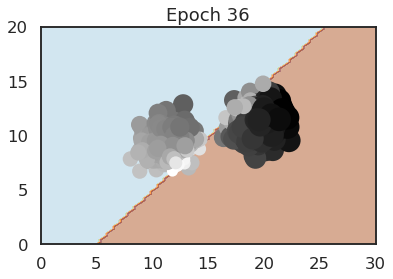

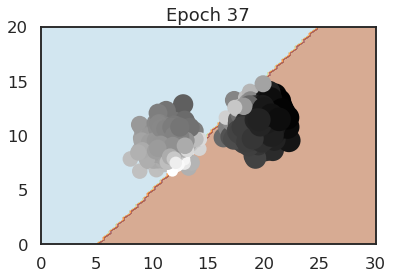

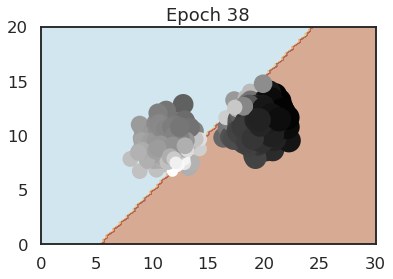

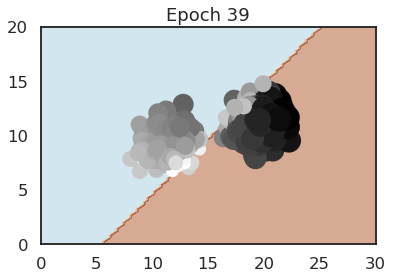

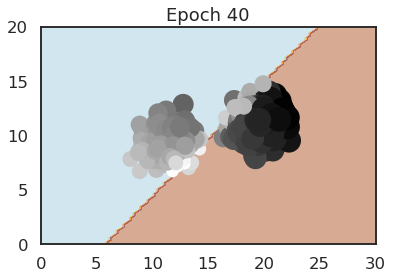

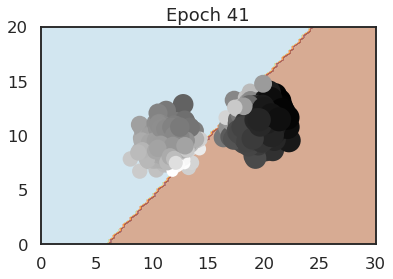

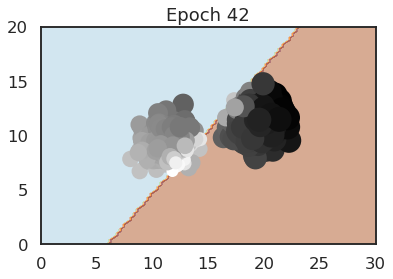

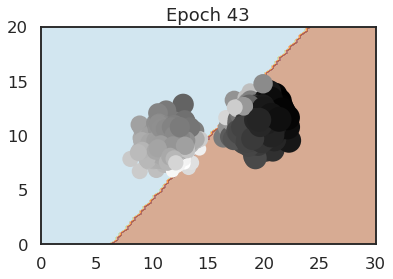

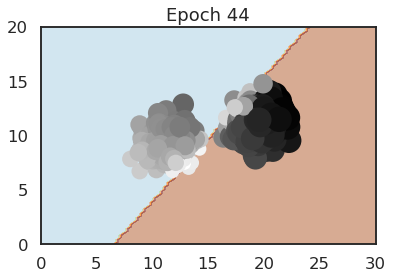

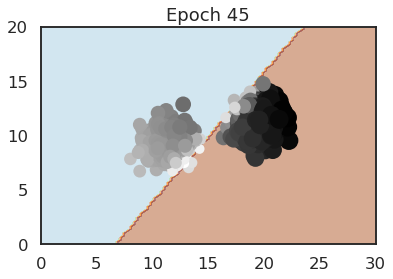

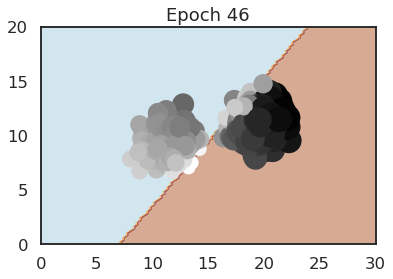

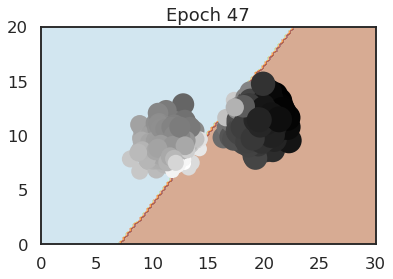

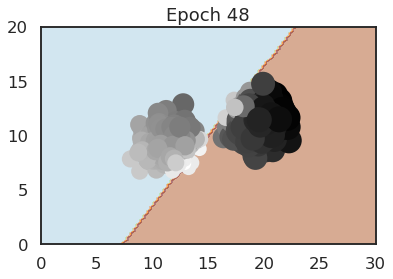

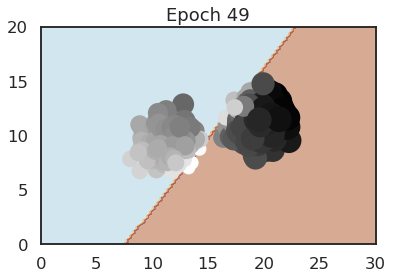

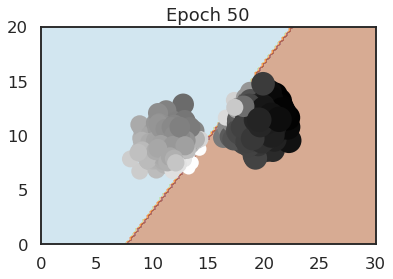

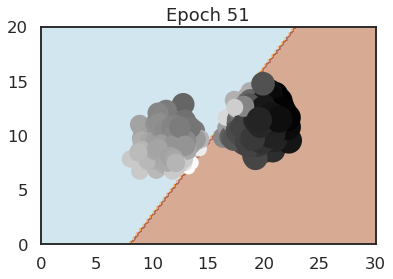

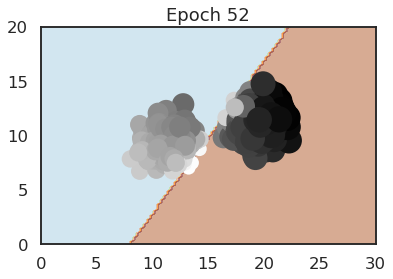

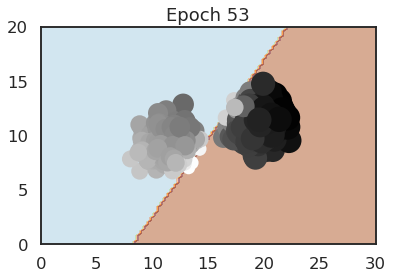

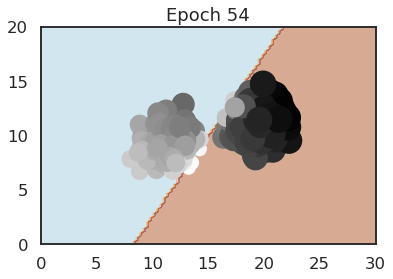

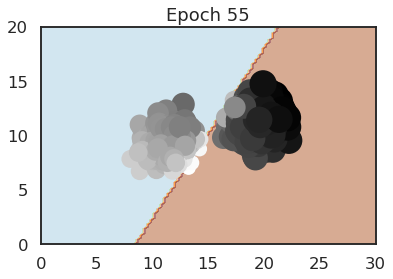

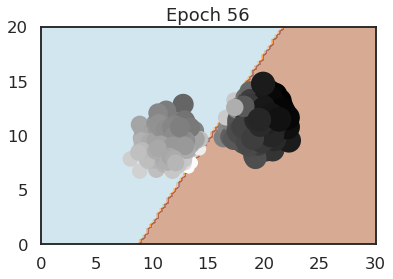

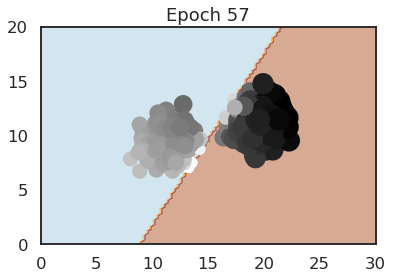

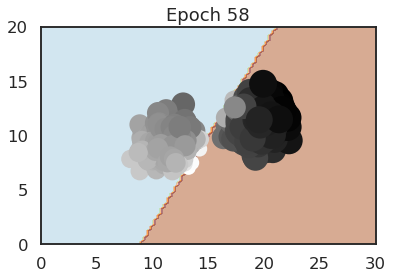

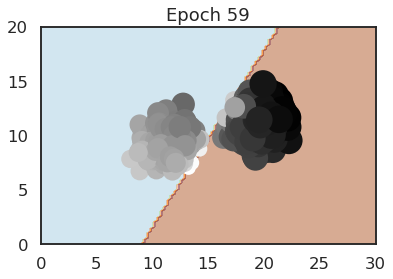

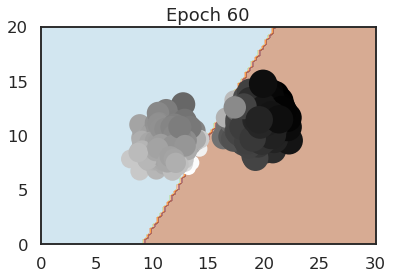

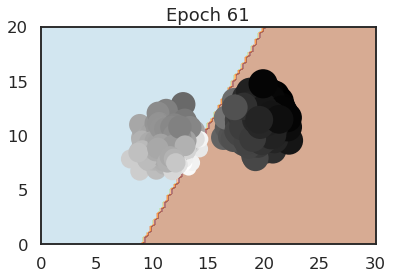

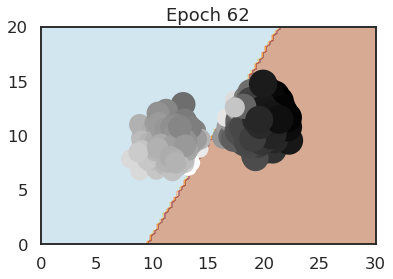

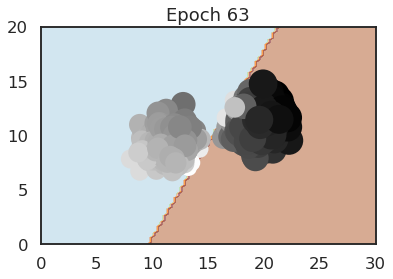

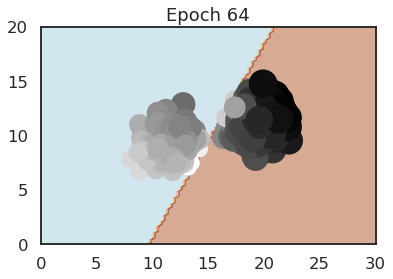

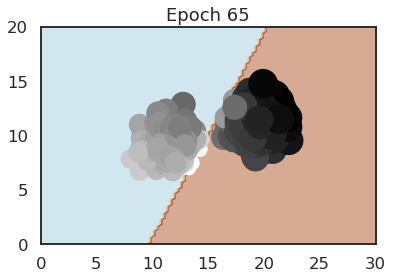

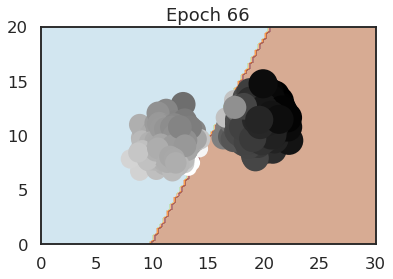

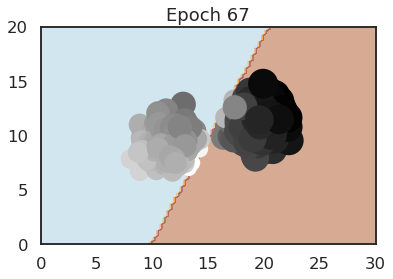

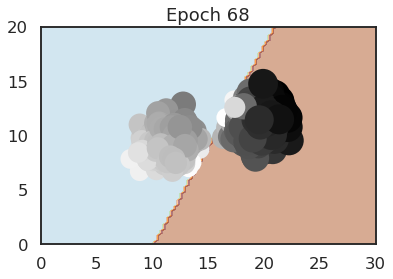

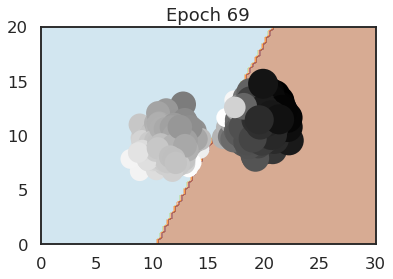

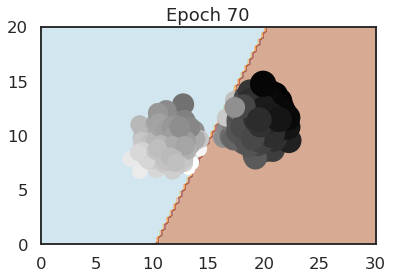

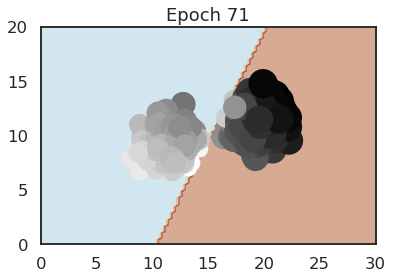

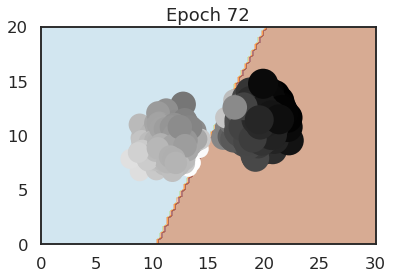

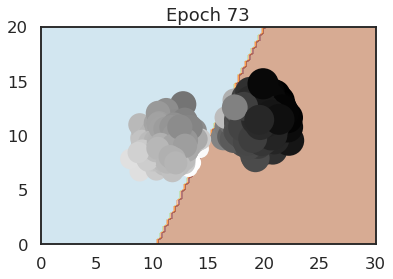

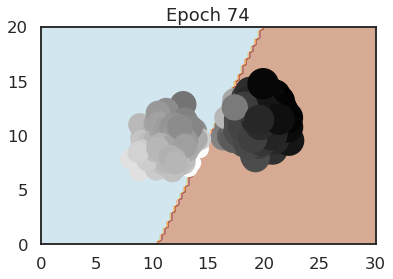

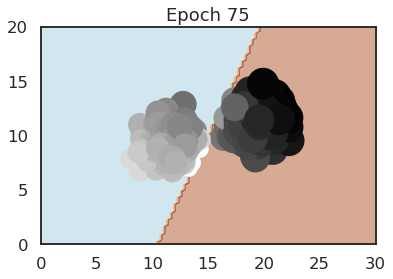

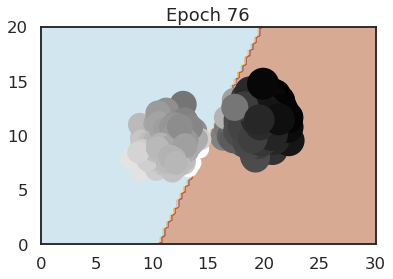

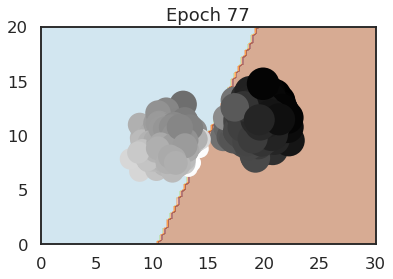

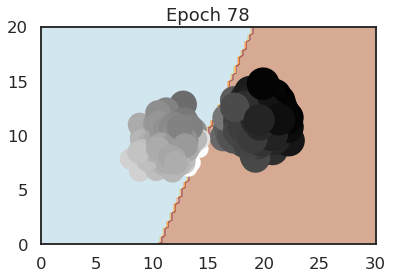

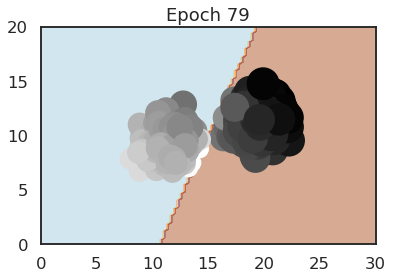

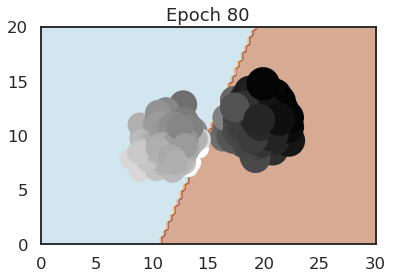

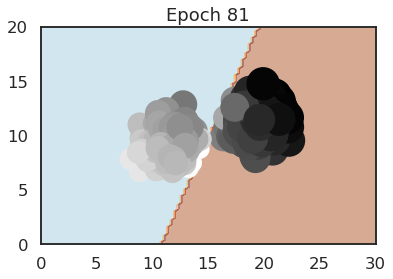

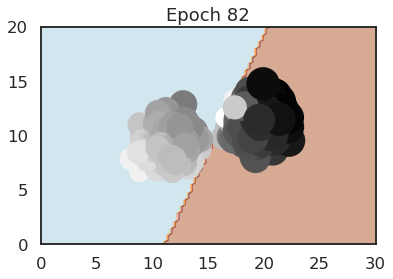

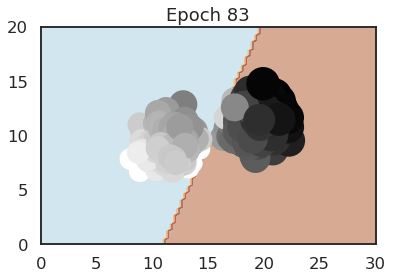

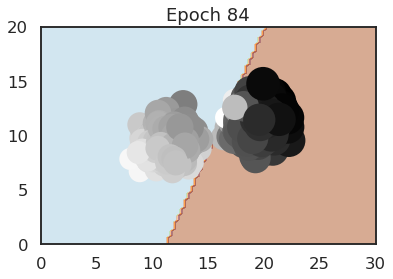

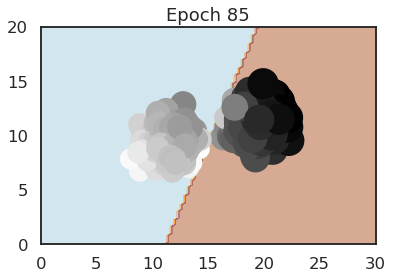

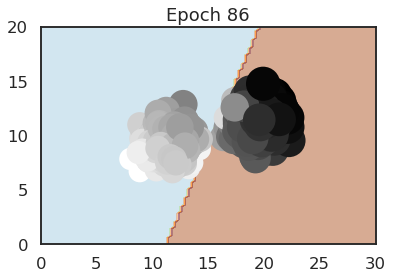

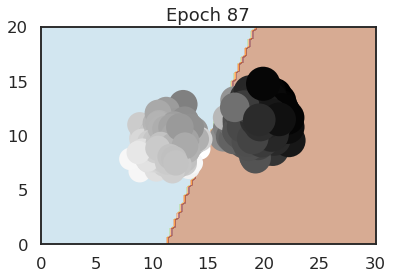

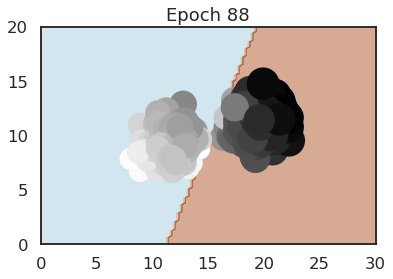

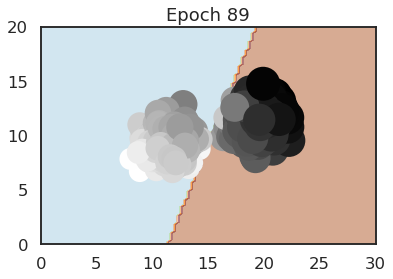

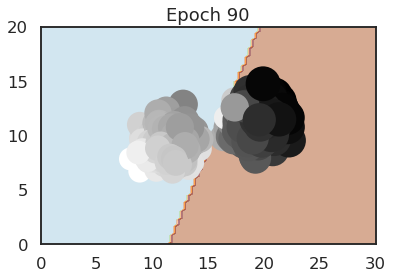

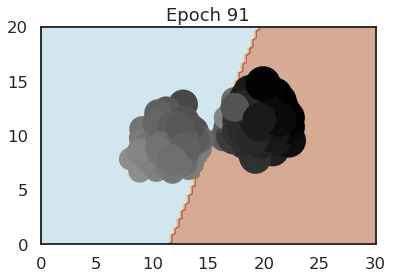

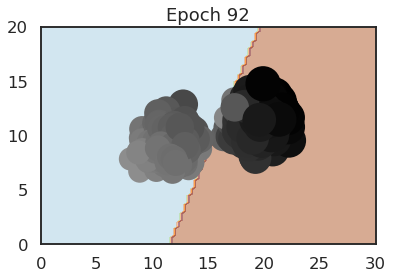

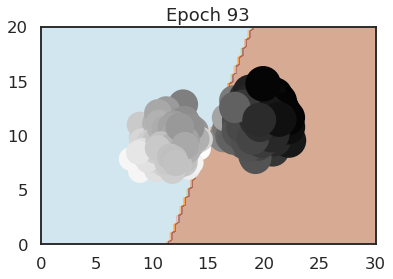

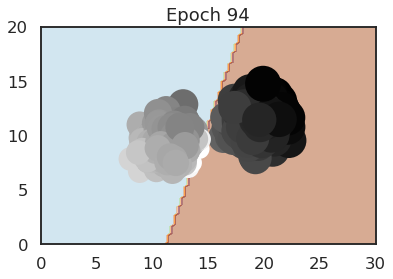

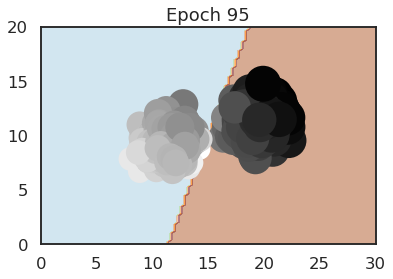

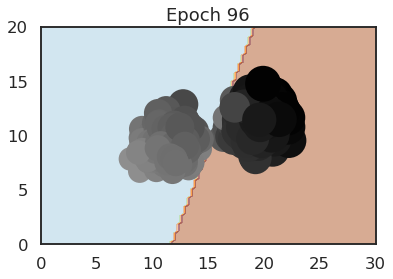

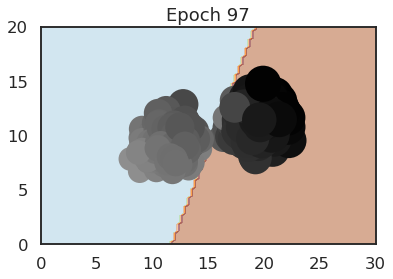

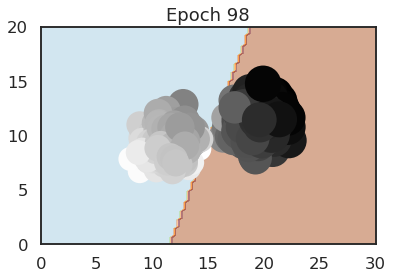

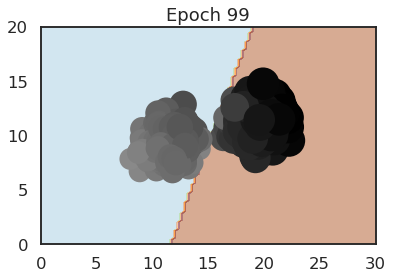

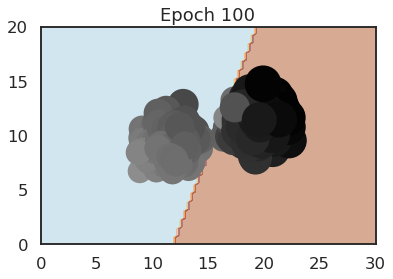

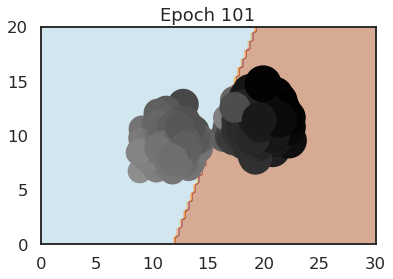

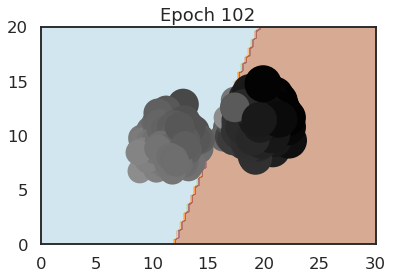

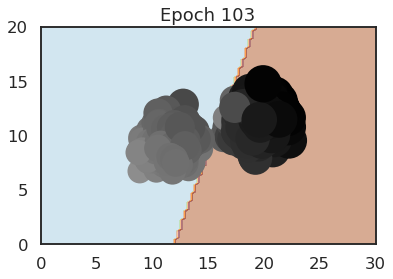

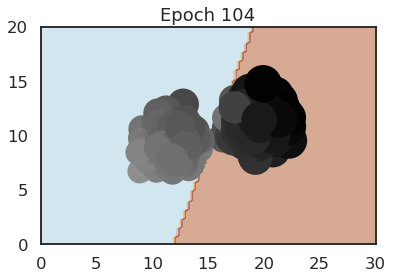

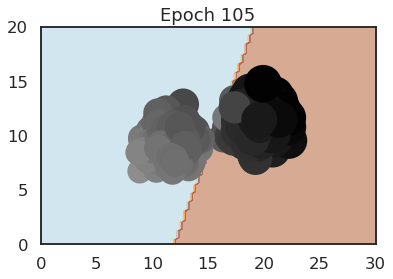

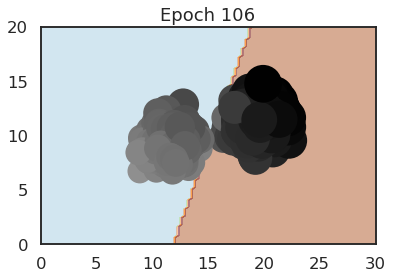

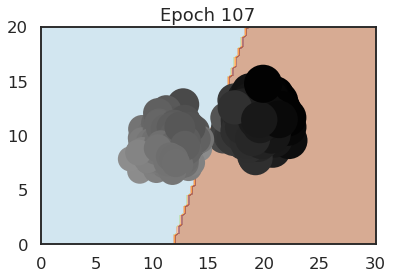

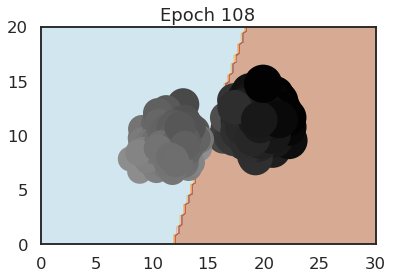

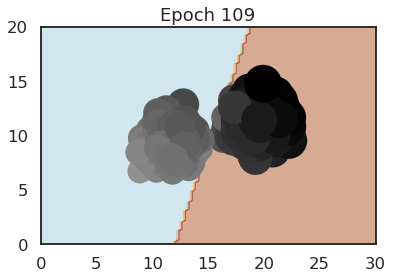

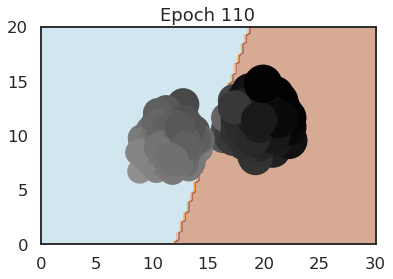

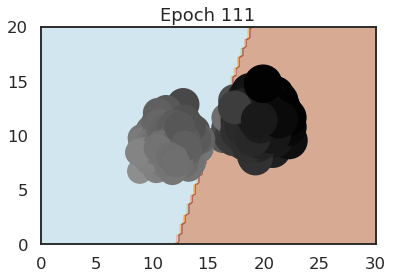

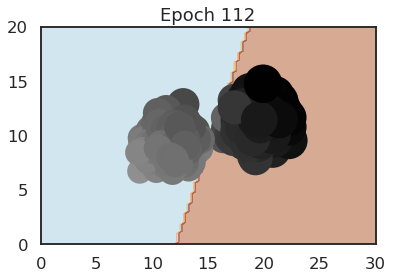

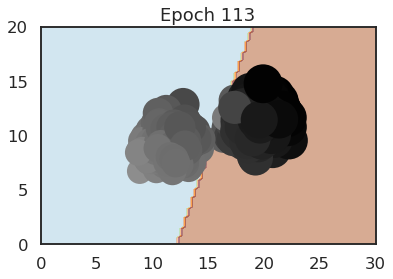

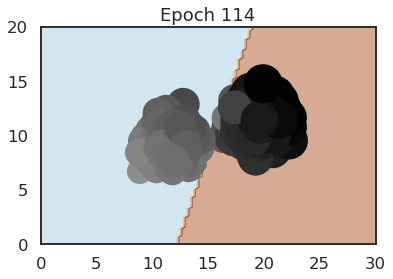

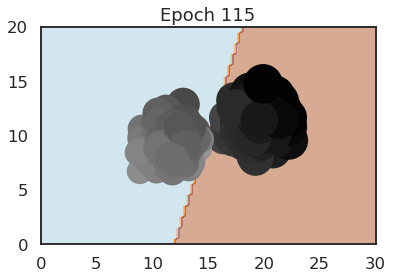

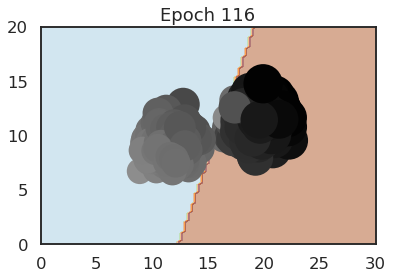

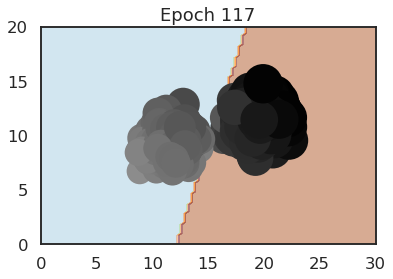

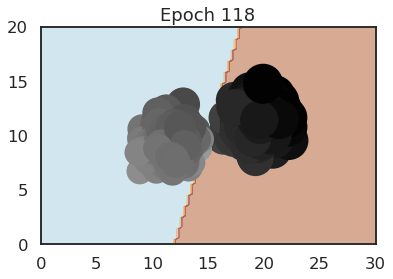

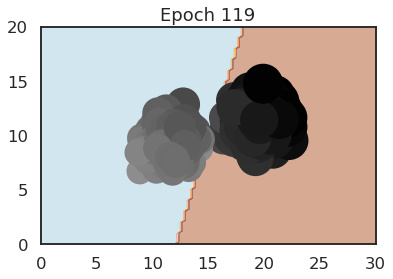

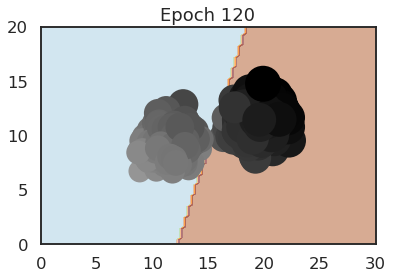

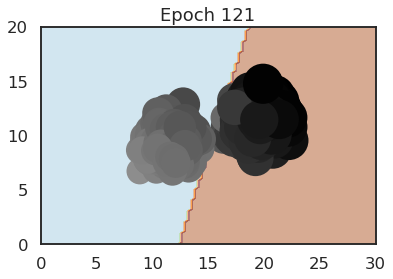

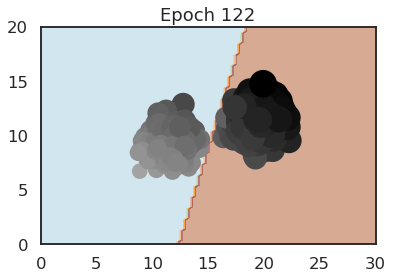

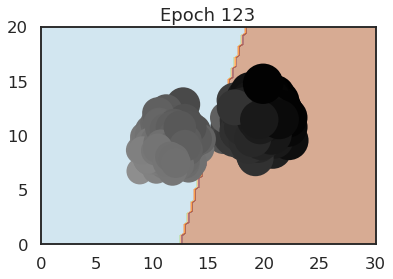

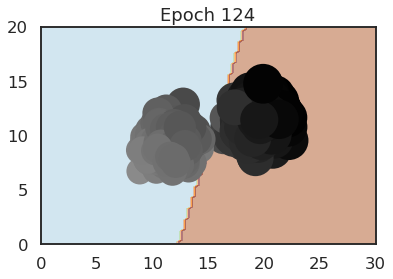

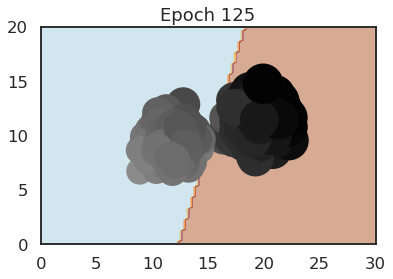

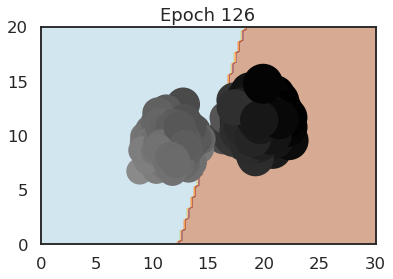

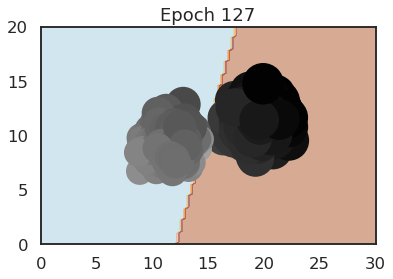

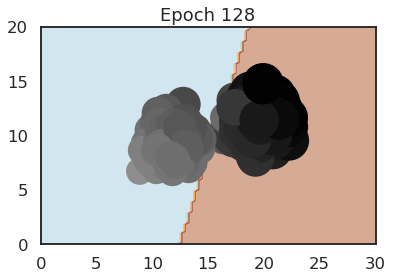

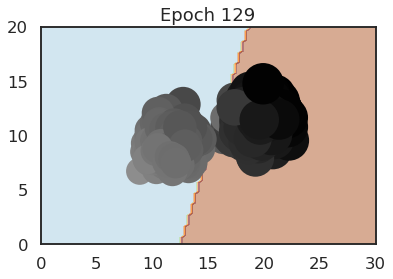

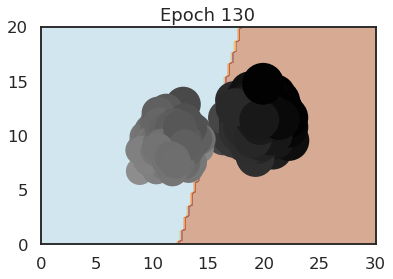

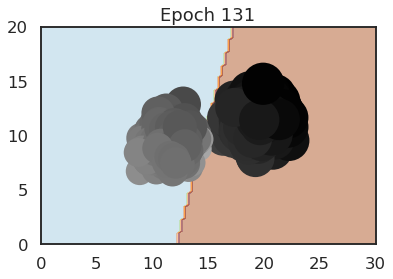

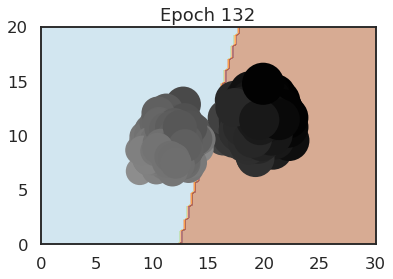

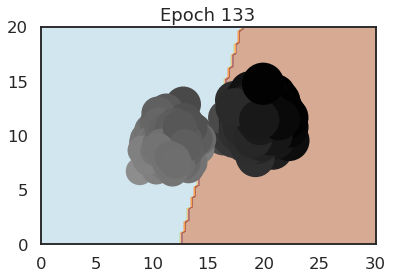

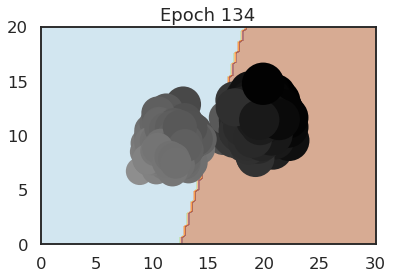

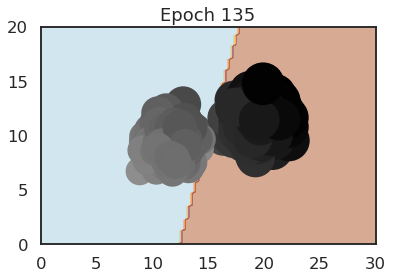

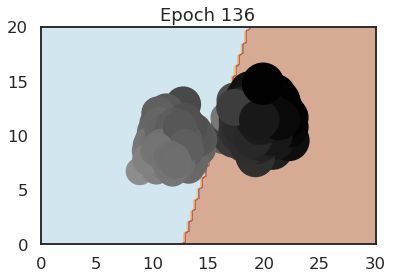

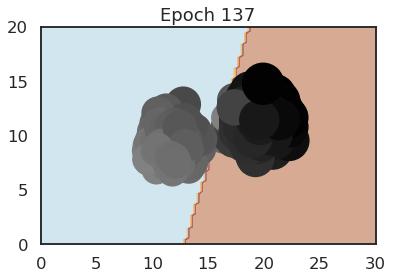

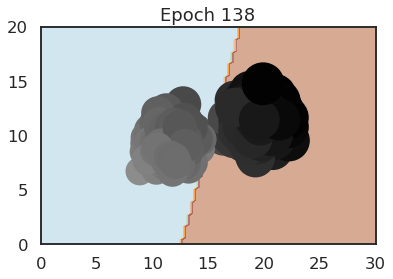

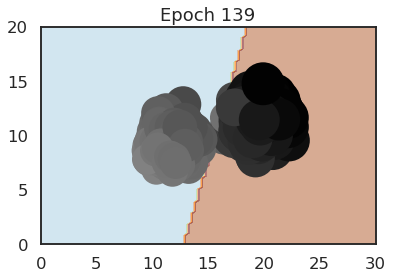

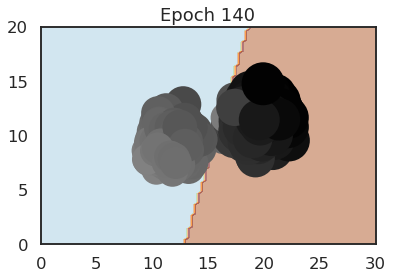

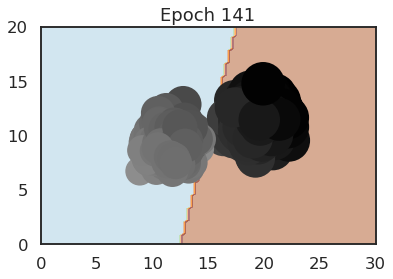

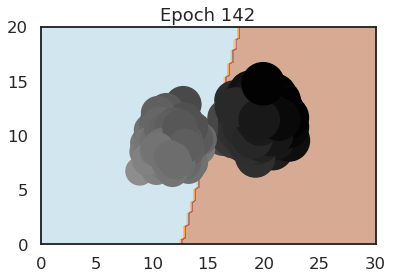

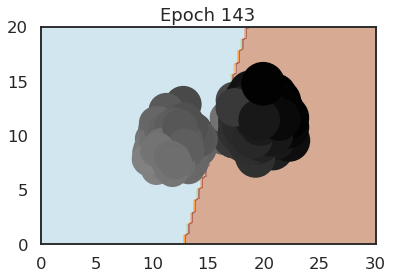

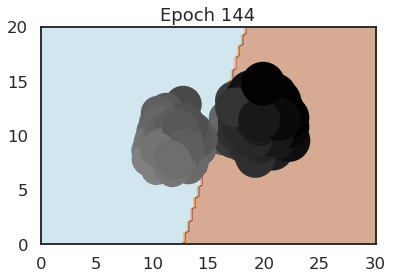

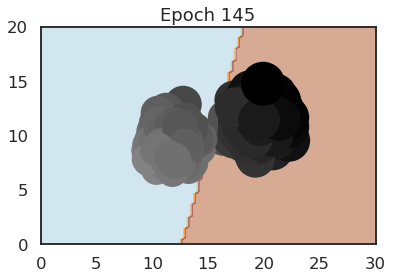

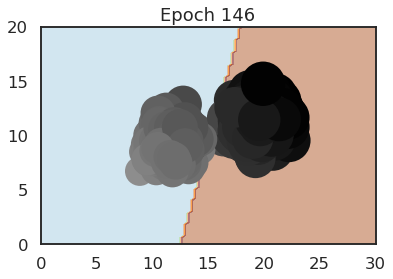

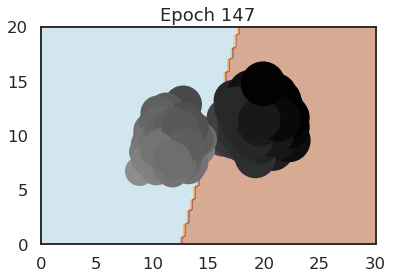

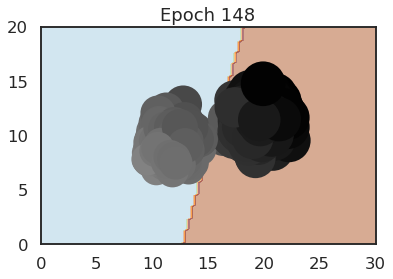

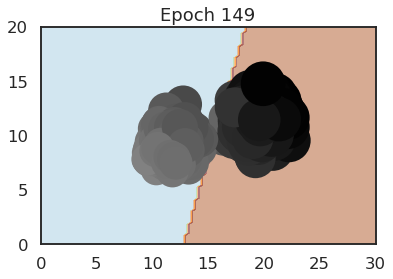

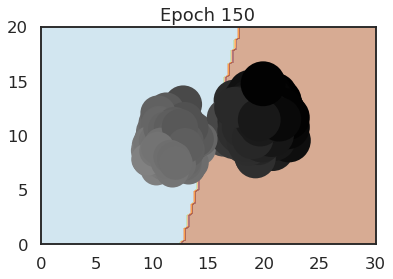

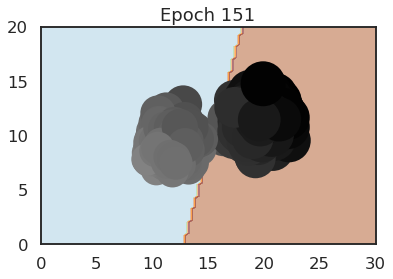

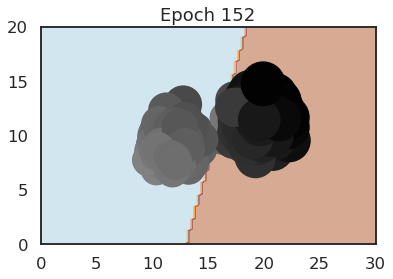

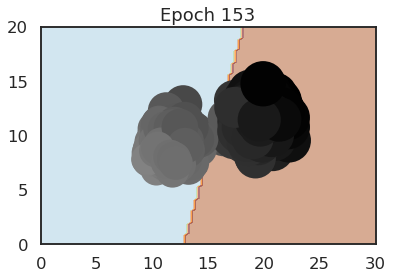

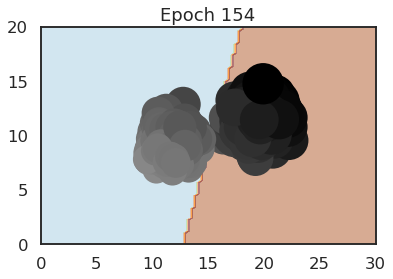

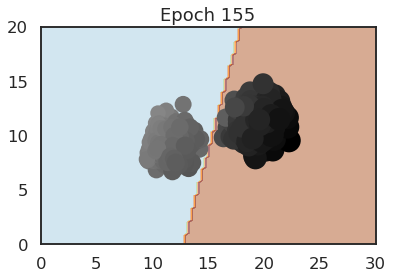

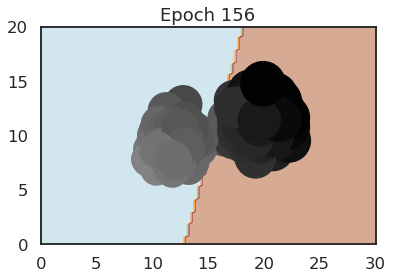

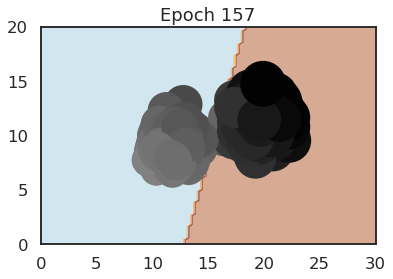

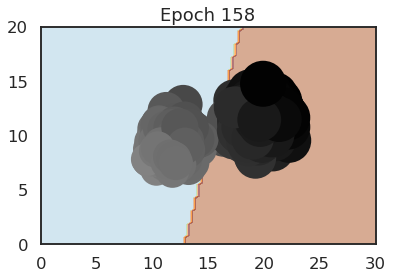

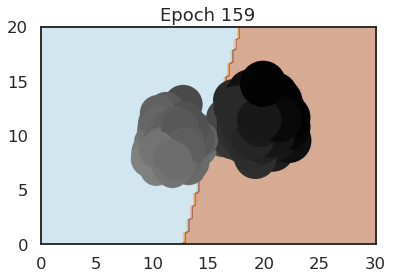

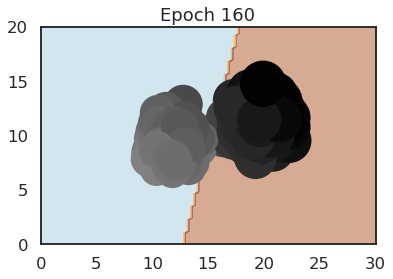

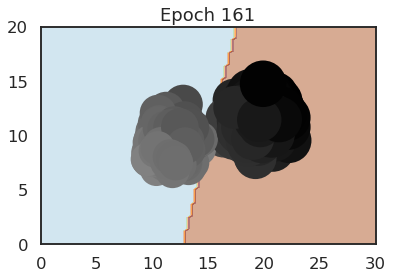

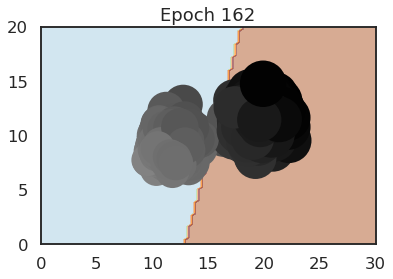

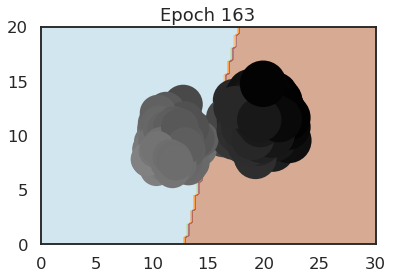

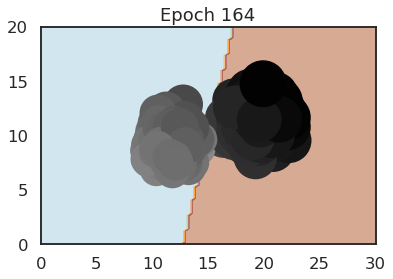

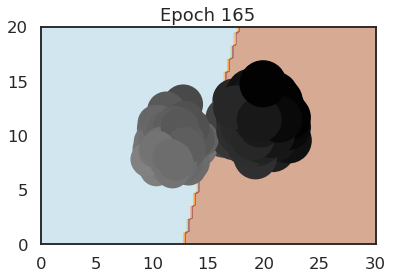

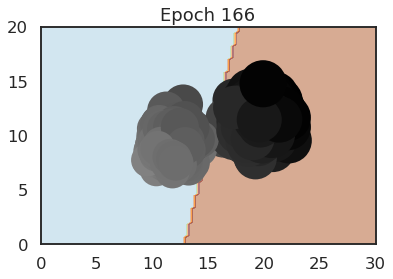

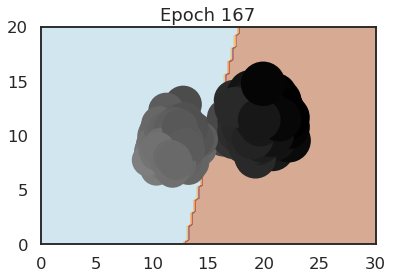

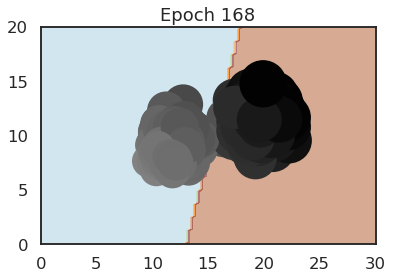

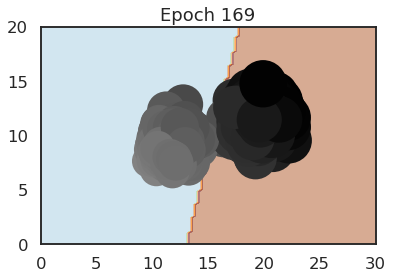

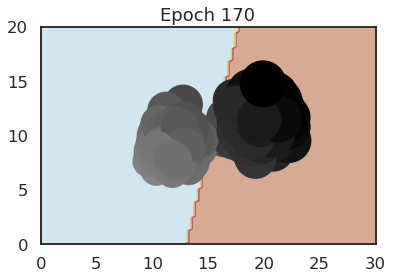

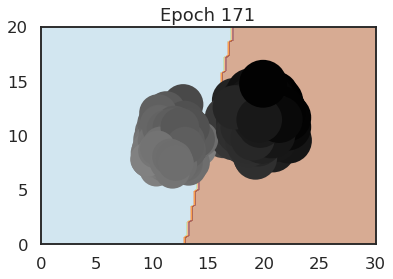

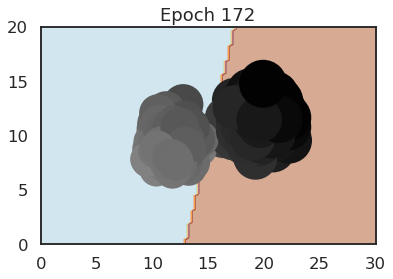

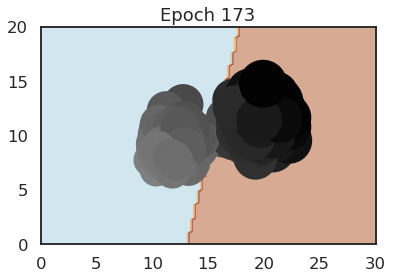

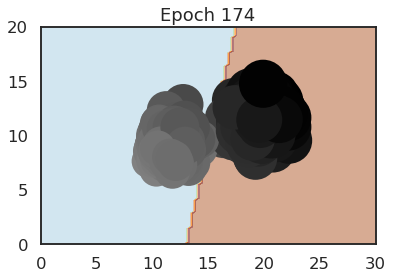

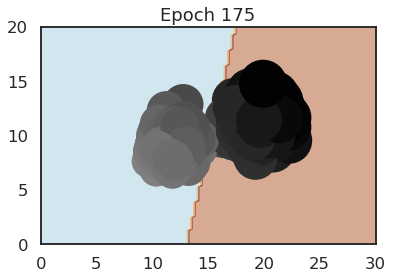

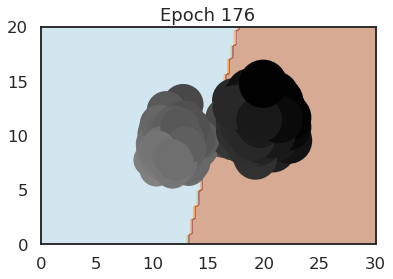

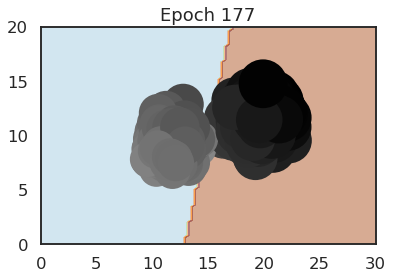

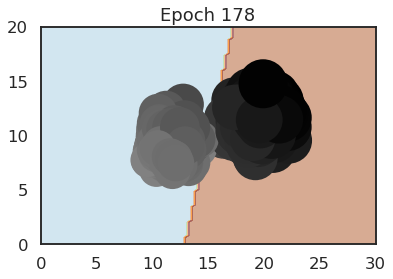

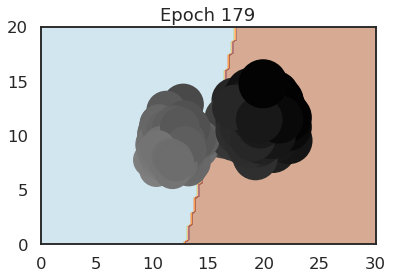

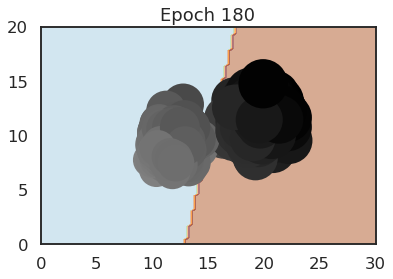

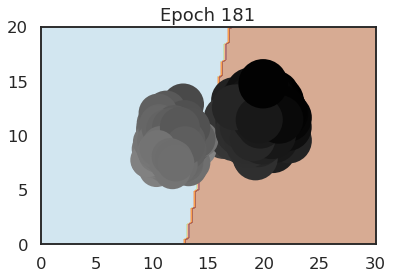

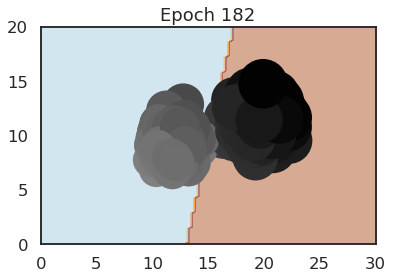

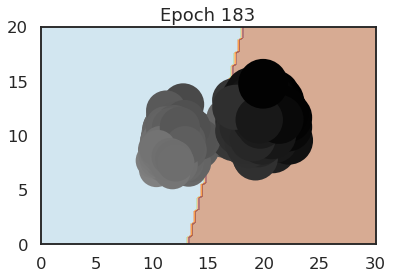

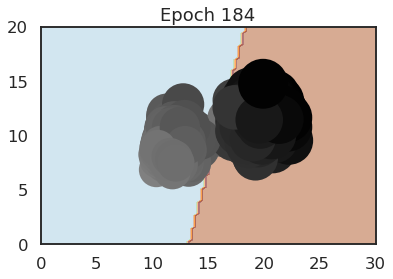

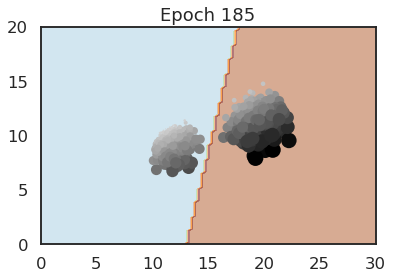

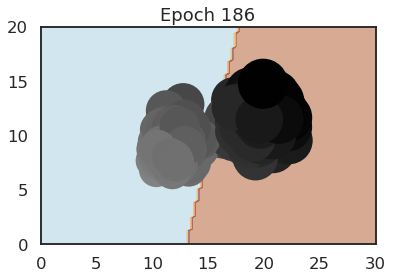

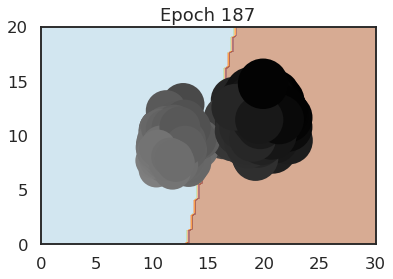

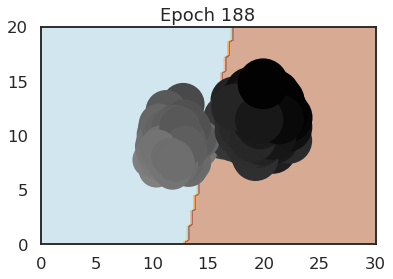

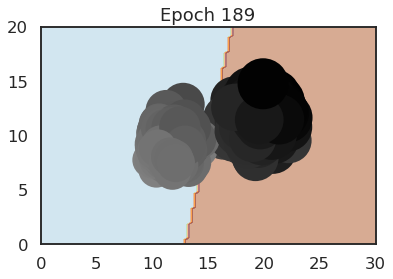

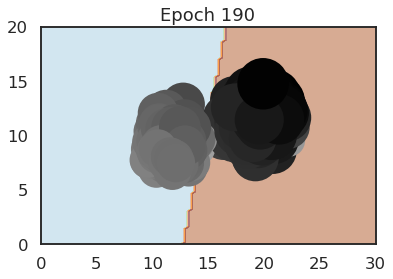

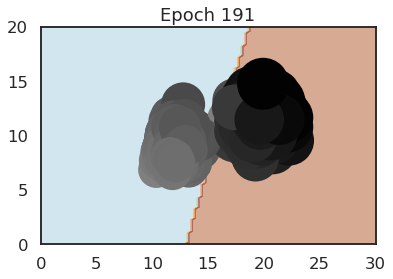

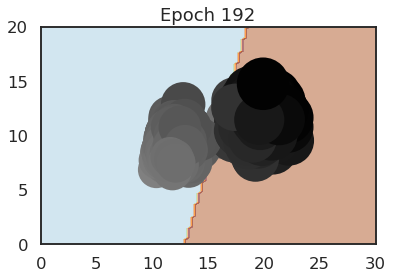

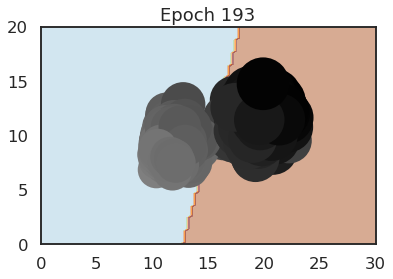

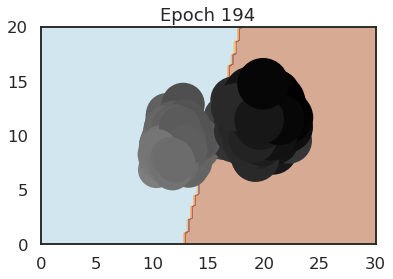

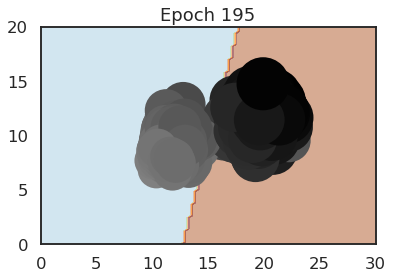

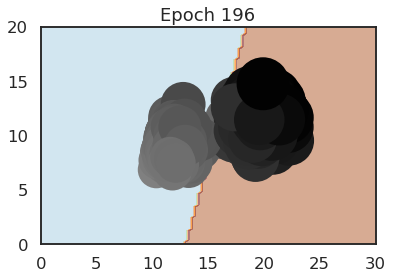

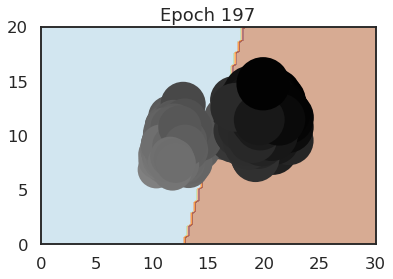

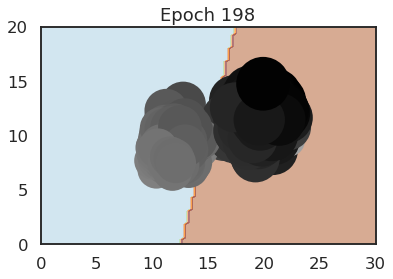

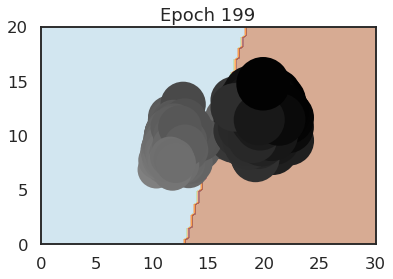

In [136]:
final_acc, info_tuple, model = run_experiment(10.1)
print("Final accuracy:", final_acc)

## Decision Boundary

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f12d8acd470>)

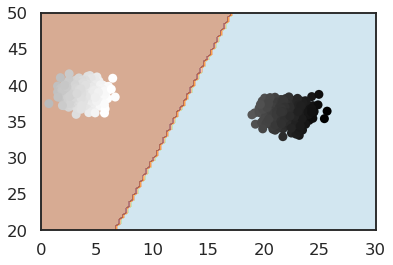

In [114]:
plot_decision_boundary(X, y, model, nn.BCELoss(), steps=100)

# IS does *NOT* Increase Per Batch

Text(0, 0.5, 'Mean Sensitivity')

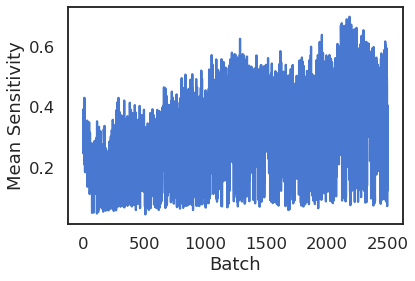

In [163]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs, all_means)
batch_mean_sensitivities = info_tuple[6]
batch_max_sensitivities = info_tuple[7]

plt.plot(batch_mean_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Mean Sensitivity")

Text(0, 0.5, 'Max Sensitivity')

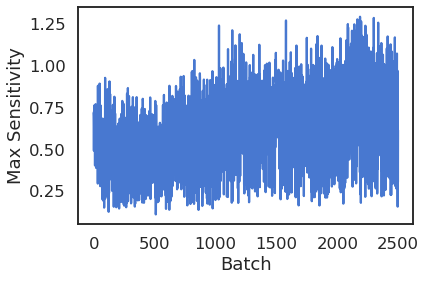

In [164]:
plt.plot(batch_max_sensitivities)
plt.xlabel("Batch")
plt.ylabel("Max Sensitivity")

# IS *DOES* Increase Per Epoch

Text(0, 0.5, 'Max Sensitivity')

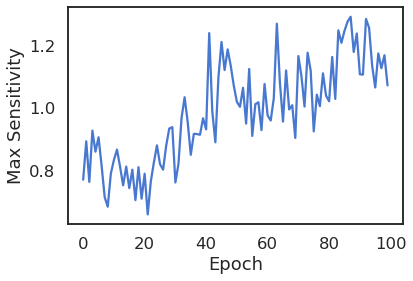

In [166]:
plt.plot(info_tuple[1])
plt.xlabel("Epoch")
plt.ylabel("Max Sensitivity")

# Accuracy Increases as Epsilon Increases

(as expected)

In [165]:
accuracies = []
epsilons = [0.01, 0.1, 1.0, 10.0]

for epsilon in epsilons:
    accuracies.append(np.mean([run_experiment(epsilon)[0] for _ in range(5)]))

Start of epoch 0
Max batch sensitivity for the epoch: 1.2892588376998901
Mean batch sensitivity for the epoch: 0.996284327507019
Max sigma for the epoch: 729.3149334738231
Mean sigma for the epoch: 563.583523176074
Accuracy: 0.47
Start of epoch 1
Max batch sensitivity for the epoch: 1.3398288488388062
Mean batch sensitivity for the epoch: 1.0052150678634644
Max sigma for the epoch: 757.9216517146284
Mean sigma for the epoch: 568.6355128297209
Accuracy: 0.48
Start of epoch 2
Max batch sensitivity for the epoch: 1.403107762336731
Mean batch sensitivity for the epoch: 1.0251167559623717
Max sigma for the epoch: 793.7176107870281
Mean sigma for the epoch: 579.8936077191586
Accuracy: 0.485
Start of epoch 3
Max batch sensitivity for the epoch: 1.3713325262069702
Mean batch sensitivity for the epoch: 1.0547149336338044
Max sigma for the epoch: 775.742822834102
Mean sigma for the epoch: 596.636865432946
Accuracy: 0.475
Start of epoch 4
Max batch sensitivity for the epoch: 1.3510774374008179
Me

Max batch sensitivity for the epoch: 1.5732700824737549
Mean batch sensitivity for the epoch: 1.1117662048339845
Max sigma for the epoch: 889.9759551640888
Mean sigma for the epoch: 628.909938025714
Accuracy: 0.475
Start of epoch 40
Max batch sensitivity for the epoch: 1.6729422807693481
Mean batch sensitivity for the epoch: 1.2087467074394227
Max sigma for the epoch: 946.3590650125561
Mean sigma for the epoch: 683.7703948538621
Accuracy: 0.48
Start of epoch 41
Max batch sensitivity for the epoch: 1.6291660070419312
Mean batch sensitivity for the epoch: 1.1125054717063905
Max sigma for the epoch: 921.595465006368
Mean sigma for the epoch: 629.3281305205819
Accuracy: 0.485
Start of epoch 42
Max batch sensitivity for the epoch: 1.7047044038772583
Mean batch sensitivity for the epoch: 1.1454692149162293
Max sigma for the epoch: 964.3264351201443
Mean sigma for the epoch: 647.9752396061572
Accuracy: 0.485
Start of epoch 43
Max batch sensitivity for the epoch: 1.4476304054260254
Mean batch 

Max batch sensitivity for the epoch: 1.4051899909973145
Mean batch sensitivity for the epoch: 1.177015504837036
Max sigma for the epoch: 794.8954971917318
Mean sigma for the epoch: 665.8205160255807
Accuracy: 0.485
Start of epoch 76
Max batch sensitivity for the epoch: 1.487892508506775
Mean batch sensitivity for the epoch: 1.134979853630066
Max sigma for the epoch: 841.6791059534427
Mean sigma for the epoch: 642.0415608095477
Accuracy: 0.48
Start of epoch 77
Max batch sensitivity for the epoch: 1.7285202741622925
Mean batch sensitivity for the epoch: 1.1374202036857606
Max sigma for the epoch: 977.7987258228699
Mean sigma for the epoch: 643.4220312678282
Accuracy: 0.475
Start of epoch 78
Max batch sensitivity for the epoch: 1.4376187324523926
Mean batch sensitivity for the epoch: 1.1229934191703796
Max sigma for the epoch: 813.2399635823166
Mean sigma for the epoch: 635.261009538594
Accuracy: 0.485
Start of epoch 79
Max batch sensitivity for the epoch: 1.5456730127334595
Mean batch se

Max batch sensitivity for the epoch: 0.47459086775779724
Mean batch sensitivity for the epoch: 0.2724243897199631
Max sigma for the epoch: 268.4691367045972
Mean sigma for the epoch: 154.1065066652741
Accuracy: 0.575
Start of epoch 12
Max batch sensitivity for the epoch: 0.4461357593536377
Mean batch sensitivity for the epoch: 0.2661735832691193
Max sigma for the epoch: 252.37249661501352
Mean sigma for the epoch: 150.5705165618531
Accuracy: 0.53
Start of epoch 13
Max batch sensitivity for the epoch: 0.5388398170471191
Mean batch sensitivity for the epoch: 0.30163339257240296
Max sigma for the epoch: 304.81383088586927
Mean sigma for the epoch: 170.6296138562001
Accuracy: 0.59
Start of epoch 14
Max batch sensitivity for the epoch: 0.5246056318283081
Mean batch sensitivity for the epoch: 0.27408954173326494
Max sigma for the epoch: 296.76175977156
Mean sigma for the epoch: 155.04845888952386
Accuracy: 0.51
Start of epoch 15
Max batch sensitivity for the epoch: 0.4640744924545288
Mean ba

Max batch sensitivity for the epoch: 0.7061618566513062
Mean batch sensitivity for the epoch: 0.4209250503778458
Max sigma for the epoch: 399.465469962737
Mean sigma for the epoch: 238.1111659947711
Accuracy: 0.645
Start of epoch 48
Max batch sensitivity for the epoch: 0.5802509188652039
Mean batch sensitivity for the epoch: 0.36250268906354904
Max sigma for the epoch: 328.2394876154487
Mean sigma for the epoch: 205.06248770815523
Accuracy: 0.695
Start of epoch 49
Max batch sensitivity for the epoch: 0.6646037101745605
Mean batch sensitivity for the epoch: 0.4111772936582565
Max sigma for the epoch: 375.9566322129365
Mean sigma for the epoch: 232.59700209254845
Accuracy: 0.63
Start of epoch 50
Max batch sensitivity for the epoch: 0.5891638398170471
Mean batch sensitivity for the epoch: 0.4342102372646332
Max sigma for the epoch: 333.2813970916311
Mean sigma for the epoch: 245.62640258435349
Accuracy: 0.665
Start of epoch 51
Max batch sensitivity for the epoch: 0.6208943724632263
Mean b

Max batch sensitivity for the epoch: 0.675095796585083
Mean batch sensitivity for the epoch: 0.3932668781280518
Max sigma for the epoch: 381.891852572677
Mean sigma for the epoch: 222.46534107232716
Accuracy: 0.68
Start of epoch 84
Max batch sensitivity for the epoch: 0.6736589074134827
Mean batch sensitivity for the epoch: 0.4053970086574554
Max sigma for the epoch: 381.0790253110353
Mean sigma for the epoch: 229.3271791155426
Accuracy: 0.73
Start of epoch 85
Max batch sensitivity for the epoch: 0.7121737003326416
Mean batch sensitivity for the epoch: 0.44546490848064424
Max sigma for the epoch: 402.86628231034166
Mean sigma for the epoch: 251.9930060538466
Accuracy: 0.64
Start of epoch 86
Max batch sensitivity for the epoch: 0.6459718942642212
Mean batch sensitivity for the epoch: 0.4419156116247177
Max sigma for the epoch: 365.4168855121202
Mean sigma for the epoch: 249.98522055363085
Accuracy: 0.68
Start of epoch 87
Max batch sensitivity for the epoch: 0.8686721920967102
Mean batch

Max batch sensitivity for the epoch: 0.43746569752693176
Mean batch sensitivity for the epoch: 0.28072060883045197
Max sigma for the epoch: 247.4679690062372
Mean sigma for the epoch: 158.79955689826303
Accuracy: 0.455
Start of epoch 20
Max batch sensitivity for the epoch: 0.40396997332572937
Mean batch sensitivity for the epoch: 0.23297783106565476
Max sigma for the epoch: 228.51992602749758
Mean sigma for the epoch: 131.7921633701267
Accuracy: 0.465
Start of epoch 21
Max batch sensitivity for the epoch: 0.4140041470527649
Mean batch sensitivity for the epoch: 0.23899663597345353
Max sigma for the epoch: 234.19611185629014
Mean sigma for the epoch: 135.1969135820814
Accuracy: 0.505
Start of epoch 22
Max batch sensitivity for the epoch: 0.49174365401268005
Mean batch sensitivity for the epoch: 0.24199452489614487
Max sigma for the epoch: 278.172217886254
Mean sigma for the epoch: 136.89277565126469
Accuracy: 0.465
Start of epoch 23
Max batch sensitivity for the epoch: 0.615385711193084

Max batch sensitivity for the epoch: 0.5613583922386169
Mean batch sensitivity for the epoch: 0.22393662571907044
Max sigma for the epoch: 317.5522606623231
Mean sigma for the epoch: 126.67768528159083
Accuracy: 0.61
Start of epoch 56
Max batch sensitivity for the epoch: 0.4166502058506012
Mean batch sensitivity for the epoch: 0.2533713695406914
Max sigma for the epoch: 235.69294875178483
Mean sigma for the epoch: 143.32849084859646
Accuracy: 0.555
Start of epoch 57
Max batch sensitivity for the epoch: 0.5796936750411987
Mean batch sensitivity for the epoch: 0.2908140164613724
Max sigma for the epoch: 327.92426290606596
Mean sigma for the epoch: 164.50925048314613
Accuracy: 0.56
Start of epoch 58
Max batch sensitivity for the epoch: 0.4424888789653778
Mean batch sensitivity for the epoch: 0.2666213074326515
Max sigma for the epoch: 250.3095095328417
Mean sigma for the epoch: 150.82378759556093
Accuracy: 0.58
Start of epoch 59
Max batch sensitivity for the epoch: 0.468807578086853
Mean 

Max batch sensitivity for the epoch: 0.5838159918785095
Mean batch sensitivity for the epoch: 0.3440401804447174
Max sigma for the epoch: 330.2561974579555
Mean sigma for the epoch: 194.61851567448247
Accuracy: 0.625
Start of epoch 92
Max batch sensitivity for the epoch: 0.6171576976776123
Mean batch sensitivity for the epoch: 0.3590932512283325
Max sigma for the epoch: 349.1171144714535
Mean sigma for the epoch: 203.13381841750277
Accuracy: 0.59
Start of epoch 93
Max batch sensitivity for the epoch: 0.6279788613319397
Mean batch sensitivity for the epoch: 0.39028650999069214
Max sigma for the epoch: 355.23848903169693
Mean sigma for the epoch: 220.7793902560397
Accuracy: 0.535
Start of epoch 94
Max batch sensitivity for the epoch: 0.7138300538063049
Mean batch sensitivity for the epoch: 0.43192798852920533
Max sigma for the epoch: 403.80325732895705
Mean sigma for the epoch: 244.33536773861314
Accuracy: 0.685
Start of epoch 95
Max batch sensitivity for the epoch: 0.7559072971343994
Me

Max batch sensitivity for the epoch: 0.8731192350387573
Mean batch sensitivity for the epoch: 0.6107435739040374
Max sigma for the epoch: 493.91082550425307
Mean sigma for the epoch: 345.4887381389217
Accuracy: 0.475
Start of epoch 28
Max batch sensitivity for the epoch: 0.8906576633453369
Mean batch sensitivity for the epoch: 0.606193368434906
Max sigma for the epoch: 503.83205877380226
Mean sigma for the epoch: 342.91475322450975
Accuracy: 0.47
Start of epoch 29
Max batch sensitivity for the epoch: 0.7943335175514221
Mean batch sensitivity for the epoch: 0.5808001792430878
Max sigma for the epoch: 449.34289342749923
Mean sigma for the epoch: 328.5501962057197
Accuracy: 0.48
Start of epoch 30
Max batch sensitivity for the epoch: 0.861449658870697
Mean batch sensitivity for the epoch: 0.5658954203128814
Max sigma for the epoch: 487.3095163506464
Mean sigma for the epoch: 320.11879131652006
Accuracy: 0.475
Start of epoch 31
Max batch sensitivity for the epoch: 0.9622460603713989
Mean ba

Max batch sensitivity for the epoch: 0.6353068351745605
Mean batch sensitivity for the epoch: 0.37674378991127017
Max sigma for the epoch: 359.3838170288768
Mean sigma for the epoch: 213.1184708929433
Accuracy: 0.505
Start of epoch 64
Max batch sensitivity for the epoch: 0.6085109710693359
Mean batch sensitivity for the epoch: 0.37841211676597597
Max sigma for the epoch: 344.2257872556308
Mean sigma for the epoch: 214.0622190787018
Accuracy: 0.43
Start of epoch 65
Max batch sensitivity for the epoch: 0.5530071258544922
Mean batch sensitivity for the epoch: 0.34792620718479156
Max sigma for the epoch: 312.8280709889552
Mean sigma for the epoch: 196.81678436230547
Accuracy: 0.405
Start of epoch 66
Max batch sensitivity for the epoch: 0.6401135325431824
Mean batch sensitivity for the epoch: 0.33678518086671827
Max sigma for the epoch: 362.10289567244797
Mean sigma for the epoch: 190.5144681551955
Accuracy: 0.505
Start of epoch 67
Max batch sensitivity for the epoch: 0.60903000831604
Mean 

Max batch sensitivity for the epoch: 0.5048521161079407
Mean batch sensitivity for the epoch: 0.24940947979688644
Max sigma for the epoch: 285.58748383704244
Mean sigma for the epoch: 141.0873075652701
Accuracy: 0.57
Start of epoch 0
Max batch sensitivity for the epoch: 1.1070257425308228
Mean batch sensitivity for the epoch: 0.7191936314105988
Max sigma for the epoch: 626.2283275932942
Mean sigma for the epoch: 406.83735500529025
Accuracy: 0.48
Start of epoch 1
Max batch sensitivity for the epoch: 0.9471963047981262
Mean batch sensitivity for the epoch: 0.7133063066005707
Max sigma for the epoch: 535.815144190076
Mean sigma for the epoch: 403.50698116831524
Accuracy: 0.5
Start of epoch 2
Max batch sensitivity for the epoch: 1.0838602781295776
Mean batch sensitivity for the epoch: 0.7055032169818878
Max sigma for the epoch: 613.1239620193294
Mean sigma for the epoch: 399.09288710145375
Accuracy: 0.48
Start of epoch 3
Max batch sensitivity for the epoch: 0.9994747638702393
Mean batch se

Max batch sensitivity for the epoch: 1.0226517915725708
Mean batch sensitivity for the epoch: 0.6439788520336152
Max sigma for the epoch: 578.4992132908293
Mean sigma for the epoch: 364.2894505709581
Accuracy: 0.545
Start of epoch 36
Max batch sensitivity for the epoch: 0.8426846265792847
Mean batch sensitivity for the epoch: 0.5904601779580116
Max sigma for the epoch: 476.6944110846926
Mean sigma for the epoch: 334.0147166837805
Accuracy: 0.635
Start of epoch 37
Max batch sensitivity for the epoch: 1.0139832496643066
Mean batch sensitivity for the epoch: 0.6605948901176453
Max sigma for the epoch: 573.5955454777626
Mean sigma for the epoch: 373.68890113549537
Accuracy: 0.59
Start of epoch 38
Max batch sensitivity for the epoch: 0.8874937295913696
Mean batch sensitivity for the epoch: 0.6557861864566803
Max sigma for the epoch: 502.0422675636781
Mean sigma for the epoch: 370.96868756158744
Accuracy: 0.58
Start of epoch 39
Max batch sensitivity for the epoch: 0.8948981761932373
Mean bat

Max batch sensitivity for the epoch: 0.7714152336120605
Mean batch sensitivity for the epoch: 0.41414757251739504
Max sigma for the epoch: 436.3783542381542
Mean sigma for the epoch: 234.277245551198
Accuracy: 0.615
Start of epoch 72
Max batch sensitivity for the epoch: 0.8427051305770874
Mean batch sensitivity for the epoch: 0.5006846106052398
Max sigma for the epoch: 476.7060098974028
Mean sigma for the epoch: 283.22998671576886
Accuracy: 0.65
Start of epoch 73
Max batch sensitivity for the epoch: 0.7665875554084778
Mean batch sensitivity for the epoch: 0.43497998476028443
Max sigma for the epoch: 433.6474070420423
Mean sigma for the epoch: 246.0618375235346
Accuracy: 0.635
Start of epoch 74
Max batch sensitivity for the epoch: 0.8029308319091797
Mean batch sensitivity for the epoch: 0.49564826130867007
Max sigma for the epoch: 454.20626885338953
Mean sigma for the epoch: 280.380997323746
Accuracy: 0.65
Start of epoch 75
Max batch sensitivity for the epoch: 1.1001914739608765
Mean ba

Max batch sensitivity for the epoch: 0.6044561862945557
Mean batch sensitivity for the epoch: 0.36278569519519804
Max sigma for the epoch: 108.12840975799226
Mean sigma for the epoch: 64.89707805767853
Accuracy: 0.605
Start of epoch 8
Max batch sensitivity for the epoch: 0.7480477690696716
Mean batch sensitivity for the epoch: 0.39039473980665207
Max sigma for the epoch: 133.81485296454804
Mean sigma for the epoch: 69.83593410128137
Accuracy: 0.605
Start of epoch 9
Max batch sensitivity for the epoch: 0.7327895164489746
Mean batch sensitivity for the epoch: 0.35994695365428925
Max sigma for the epoch: 131.08537375832861
Mean sigma for the epoch: 64.38926853319657
Accuracy: 0.545
Start of epoch 10
Max batch sensitivity for the epoch: 0.6018137335777283
Mean batch sensitivity for the epoch: 0.29051293939352035
Max sigma for the epoch: 107.65571344581984
Mean sigma for the epoch: 51.96853446617504
Accuracy: 0.61
Start of epoch 11
Max batch sensitivity for the epoch: 0.8116386532783508
Mea

Max batch sensitivity for the epoch: 1.0775456428527832
Mean batch sensitivity for the epoch: 0.6138260674476623
Max sigma for the epoch: 192.7572245022027
Mean sigma for the epoch: 109.8045450539475
Accuracy: 0.74
Start of epoch 44
Max batch sensitivity for the epoch: 0.8546424508094788
Mean batch sensitivity for the epoch: 0.5070825850963593
Max sigma for the epoch: 152.88308931736117
Mean sigma for the epoch: 90.70969043854248
Accuracy: 0.715
Start of epoch 45
Max batch sensitivity for the epoch: 0.9335000514984131
Mean batch sensitivity for the epoch: 0.5733511114120483
Max sigma for the epoch: 166.98956577200047
Mean sigma for the epoch: 102.56416480739162
Accuracy: 0.7
Start of epoch 46
Max batch sensitivity for the epoch: 0.9373474717140198
Mean batch sensitivity for the epoch: 0.5778615587949752
Max sigma for the epoch: 167.67781322320877
Mean sigma for the epoch: 103.3710181639645
Accuracy: 0.71
Start of epoch 47
Max batch sensitivity for the epoch: 1.0789202451705933
Mean bat

Max batch sensitivity for the epoch: 1.0863794088363647
Mean batch sensitivity for the epoch: 0.7219628822803498
Max sigma for the epoch: 194.33745660113178
Mean sigma for the epoch: 129.14864656084322
Accuracy: 0.745
Start of epoch 80
Max batch sensitivity for the epoch: 0.938788652420044
Mean batch sensitivity for the epoch: 0.592485842704773
Max sigma for the epoch: 167.93561946533126
Mean sigma for the epoch: 105.98708959952961
Accuracy: 0.695
Start of epoch 81
Max batch sensitivity for the epoch: 1.3130589723587036
Mean batch sensitivity for the epoch: 0.6328711521625519
Max sigma for the epoch: 234.8871296528063
Mean sigma for the epoch: 113.21143337872633
Accuracy: 0.73
Start of epoch 82
Max batch sensitivity for the epoch: 1.007598638534546
Mean batch sensitivity for the epoch: 0.6752981454133987
Max sigma for the epoch: 180.2447239839587
Mean sigma for the epoch: 120.80100465791178
Accuracy: 0.75
Start of epoch 83
Max batch sensitivity for the epoch: 1.3050047159194946
Mean ba

Max batch sensitivity for the epoch: 1.1673102378845215
Mean batch sensitivity for the epoch: 0.7346775245666504
Max sigma for the epoch: 208.81480341929924
Mean sigma for the epoch: 131.42311091778416
Accuracy: 0.46
Start of epoch 16
Max batch sensitivity for the epoch: 0.9299537539482117
Mean batch sensitivity for the epoch: 0.7253227925300598
Max sigma for the epoch: 166.35518478074516
Mean sigma for the epoch: 129.74968557817525
Accuracy: 0.505
Start of epoch 17
Max batch sensitivity for the epoch: 0.944073498249054
Mean batch sensitivity for the epoch: 0.6985747981071472
Max sigma for the epoch: 168.88100142727308
Mean sigma for the epoch: 124.96485887486182
Accuracy: 0.495
Start of epoch 18
Max batch sensitivity for the epoch: 1.0407108068466187
Mean batch sensitivity for the epoch: 0.6951944887638092
Max sigma for the epoch: 186.16800872221543
Mean sigma for the epoch: 124.3601707567273
Accuracy: 0.46
Start of epoch 19
Max batch sensitivity for the epoch: 0.8788048028945923
Mean

Max batch sensitivity for the epoch: 1.132615327835083
Mean batch sensitivity for the epoch: 0.43764008700847623
Max sigma for the epoch: 202.60838923179642
Mean sigma for the epoch: 78.28743873839004
Accuracy: 0.55
Start of epoch 52
Max batch sensitivity for the epoch: 0.7800954580307007
Mean batch sensitivity for the epoch: 0.3770995080471039
Max sigma for the epoch: 139.54771784763847
Mean sigma for the epoch: 67.45761074200426
Accuracy: 0.555
Start of epoch 53
Max batch sensitivity for the epoch: 0.8490289449691772
Mean batch sensitivity for the epoch: 0.40556603491306303
Max sigma for the epoch: 151.87891486528068
Mean sigma for the epoch: 72.54985787445297
Accuracy: 0.54
Start of epoch 54
Max batch sensitivity for the epoch: 0.6933833360671997
Mean batch sensitivity for the epoch: 0.3934660765528679
Max sigma for the epoch: 124.03618191294721
Mean sigma for the epoch: 70.3853515209879
Accuracy: 0.54
Start of epoch 55
Max batch sensitivity for the epoch: 0.8098278641700745
Mean ba

Max batch sensitivity for the epoch: 0.6881527900695801
Mean batch sensitivity for the epoch: 0.5212966829538346
Max sigma for the epoch: 123.10051340013786
Mean sigma for the epoch: 93.2523855623944
Accuracy: 0.63
Start of epoch 88
Max batch sensitivity for the epoch: 0.8572895526885986
Mean batch sensitivity for the epoch: 0.5256684798002244
Max sigma for the epoch: 153.35661729696753
Mean sigma for the epoch: 94.03443635698213
Accuracy: 0.64
Start of epoch 89
Max batch sensitivity for the epoch: 0.8777866363525391
Mean batch sensitivity for the epoch: 0.5405371117591858
Max sigma for the epoch: 157.02324709001323
Mean sigma for the epoch: 96.69421810039523
Accuracy: 0.655
Start of epoch 90
Max batch sensitivity for the epoch: 0.8968253135681152
Mean batch sensitivity for the epoch: 0.48545609951019286
Max sigma for the epoch: 160.42898920646962
Mean sigma for the epoch: 86.8410270877355
Accuracy: 0.62
Start of epoch 91
Max batch sensitivity for the epoch: 0.7421109080314636
Mean bat

Max batch sensitivity for the epoch: 0.761069118976593
Mean batch sensitivity for the epoch: 0.3760681122541428
Max sigma for the epoch: 136.14418284860298
Mean sigma for the epoch: 67.27310905362279
Accuracy: 0.46
Start of epoch 24
Max batch sensitivity for the epoch: 0.7473077774047852
Mean batch sensitivity for the epoch: 0.3724460434913635
Max sigma for the epoch: 133.68247923131048
Mean sigma for the epoch: 66.62517369580254
Accuracy: 0.405
Start of epoch 25
Max batch sensitivity for the epoch: 0.7885936498641968
Mean batch sensitivity for the epoch: 0.39721321523189546
Max sigma for the epoch: 141.06792061768095
Mean sigma for the epoch: 71.05566006558185
Accuracy: 0.425
Start of epoch 26
Max batch sensitivity for the epoch: 0.891679048538208
Mean batch sensitivity for the epoch: 0.3488537019491196
Max sigma for the epoch: 159.5083973315014
Mean sigma for the epoch: 62.40484734085457
Accuracy: 0.465
Start of epoch 27
Max batch sensitivity for the epoch: 0.7321131229400635
Mean ba

Max batch sensitivity for the epoch: 0.6759359240531921
Mean batch sensitivity for the epoch: 0.3907818666100502
Max sigma for the epoch: 120.91509396936581
Mean sigma for the epoch: 69.9051854491462
Accuracy: 0.62
Start of epoch 60
Max batch sensitivity for the epoch: 0.6374634504318237
Mean batch sensitivity for the epoch: 0.42159872710704804
Max sigma for the epoch: 114.03292866697004
Mean sigma for the epoch: 75.41787304309942
Accuracy: 0.615
Start of epoch 61
Max batch sensitivity for the epoch: 0.6759490966796875
Mean batch sensitivity for the epoch: 0.42663231551647185
Max sigma for the epoch: 120.91745036042869
Mean sigma for the epoch: 76.31830871143755
Accuracy: 0.675
Start of epoch 62
Max batch sensitivity for the epoch: 0.8768024444580078
Mean batch sensitivity for the epoch: 0.4010464173555374
Max sigma for the epoch: 156.84718949168715
Mean sigma for the epoch: 71.74136410717865
Accuracy: 0.63
Start of epoch 63
Max batch sensitivity for the epoch: 0.6670051217079163
Mean 

Max batch sensitivity for the epoch: 1.008687138557434
Mean batch sensitivity for the epoch: 0.5577315753698349
Max sigma for the epoch: 180.43944078753375
Mean sigma for the epoch: 99.77005725799987
Accuracy: 0.725
Start of epoch 96
Max batch sensitivity for the epoch: 0.7840624451637268
Mean batch sensitivity for the epoch: 0.4794778388738632
Max sigma for the epoch: 140.25735407926354
Mean sigma for the epoch: 85.77160331413194
Accuracy: 0.735
Start of epoch 97
Max batch sensitivity for the epoch: 1.0284900665283203
Mean batch sensitivity for the epoch: 0.5496924126148224
Max sigma for the epoch: 183.98189623524843
Mean sigma for the epoch: 98.33196810580847
Accuracy: 0.755
Start of epoch 98
Max batch sensitivity for the epoch: 0.9350548386573792
Mean batch sensitivity for the epoch: 0.4849511802196503
Max sigma for the epoch: 167.26769455423982
Mean sigma for the epoch: 86.75070437919116
Accuracy: 0.76
Start of epoch 99
Max batch sensitivity for the epoch: 1.1090528964996338
Mean b

Max batch sensitivity for the epoch: 1.010589838027954
Mean batch sensitivity for the epoch: 0.6186061704158783
Max sigma for the epoch: 180.77980601608058
Mean sigma for the epoch: 110.65963586805785
Accuracy: 0.625
Start of epoch 32
Max batch sensitivity for the epoch: 1.0073540210723877
Mean batch sensitivity for the epoch: 0.6466108947992325
Max sigma for the epoch: 180.20096548204916
Mean sigma for the epoch: 115.66927326104393
Accuracy: 0.595
Start of epoch 33
Max batch sensitivity for the epoch: 1.0561031103134155
Mean batch sensitivity for the epoch: 0.6424251067638397
Max sigma for the epoch: 188.9214676727805
Mean sigma for the epoch: 114.92049673412046
Accuracy: 0.625
Start of epoch 34
Max batch sensitivity for the epoch: 1.096524715423584
Mean batch sensitivity for the epoch: 0.5795077419281006
Max sigma for the epoch: 196.15230421565968
Mean sigma for the epoch: 103.66549635509104
Accuracy: 0.66
Start of epoch 35
Max batch sensitivity for the epoch: 1.447986125946045
Mean 

Max batch sensitivity for the epoch: 1.2667853832244873
Mean batch sensitivity for the epoch: 0.7727510368824005
Max sigma for the epoch: 226.60945838344603
Mean sigma for the epoch: 138.23390785219956
Accuracy: 0.675
Start of epoch 68
Max batch sensitivity for the epoch: 1.2870959043502808
Mean batch sensitivity for the epoch: 0.7426698994636536
Max sigma for the epoch: 230.2427148551036
Mean sigma for the epoch: 132.85283040349313
Accuracy: 0.68
Start of epoch 69
Max batch sensitivity for the epoch: 1.6278622150421143
Mean batch sensitivity for the epoch: 0.7732697033882141
Max sigma for the epoch: 291.2008456670039
Mean sigma for the epoch: 138.32668973737168
Accuracy: 0.68
Start of epoch 70
Max batch sensitivity for the epoch: 1.1675028800964355
Mean batch sensitivity for the epoch: 0.7273587930202484
Max sigma for the epoch: 208.8492643057933
Mean sigma for the epoch: 130.113896418038
Accuracy: 0.66
Start of epoch 71
Max batch sensitivity for the epoch: 1.3545258045196533
Mean bat

Max batch sensitivity for the epoch: 1.1839208602905273
Mean batch sensitivity for the epoch: 0.8901472902297973
Max sigma for the epoch: 211.78620188717204
Mean sigma for the epoch: 159.23438807528493
Accuracy: 0.5
Start of epoch 4
Max batch sensitivity for the epoch: 1.2646924257278442
Mean batch sensitivity for the epoch: 0.8991962218284607
Max sigma for the epoch: 226.2350587645251
Mean sigma for the epoch: 160.8531101695535
Accuracy: 0.505
Start of epoch 5
Max batch sensitivity for the epoch: 1.1280170679092407
Mean batch sensitivity for the epoch: 0.8866306936740875
Max sigma for the epoch: 201.7858274900047
Mean sigma for the epoch: 158.6053201594442
Accuracy: 0.49
Start of epoch 6
Max batch sensitivity for the epoch: 1.4399036169052124
Mean batch sensitivity for the epoch: 0.8887738466262818
Max sigma for the epoch: 257.5777894758296
Mean sigma for the epoch: 158.98869901442703
Accuracy: 0.5
Start of epoch 7
Max batch sensitivity for the epoch: 1.1400346755981445
Mean batch sen

Max batch sensitivity for the epoch: 1.1050199270248413
Mean batch sensitivity for the epoch: 0.5899449557065963
Max sigma for the epoch: 197.67197386555216
Mean sigma for the epoch: 105.53256191544415
Accuracy: 0.725
Start of epoch 40
Max batch sensitivity for the epoch: 1.0756409168243408
Mean batch sensitivity for the epoch: 0.6268387424945832
Max sigma for the epoch: 192.41649675195387
Mean sigma for the epoch: 112.13232313186991
Accuracy: 0.715
Start of epoch 41
Max batch sensitivity for the epoch: 0.9871292114257812
Mean batch sensitivity for the epoch: 0.6800553262233734
Max sigma for the epoch: 176.5830415459047
Mean sigma for the epoch: 121.65199503170066
Accuracy: 0.735
Start of epoch 42
Max batch sensitivity for the epoch: 0.9449785351753235
Mean batch sensitivity for the epoch: 0.6429515707492829
Max sigma for the epoch: 169.04289935441597
Mean sigma for the epoch: 115.01467347485296
Accuracy: 0.73
Start of epoch 43
Max batch sensitivity for the epoch: 0.9646654725074768
Me

Max batch sensitivity for the epoch: 1.1443699598312378
Mean batch sensitivity for the epoch: 0.6854695510864258
Max sigma for the epoch: 204.7111217273081
Mean sigma for the epoch: 122.620521018841
Accuracy: 0.77
Start of epoch 76
Max batch sensitivity for the epoch: 1.1301404237747192
Mean batch sensitivity for the epoch: 0.6603866291046142
Max sigma for the epoch: 202.16566493445532
Mean sigma for the epoch: 118.13355152878867
Accuracy: 0.815
Start of epoch 77
Max batch sensitivity for the epoch: 1.1187440156936646
Mean batch sensitivity for the epoch: 0.6662745320796967
Max sigma for the epoch: 200.12701348097002
Mean sigma for the epoch: 119.18681163256528
Accuracy: 0.77
Start of epoch 78
Max batch sensitivity for the epoch: 0.9890265464782715
Mean batch sensitivity for the epoch: 0.6057851833105087
Max sigma for the epoch: 176.92244715818163
Mean sigma for the epoch: 108.3661479715575
Accuracy: 0.775
Start of epoch 79
Max batch sensitivity for the epoch: 1.0813188552856445
Mean b

Max batch sensitivity for the epoch: 1.8391615152359009
Mean batch sensitivity for the epoch: 1.1321730375289918
Max sigma for the epoch: 104.0386863296505
Mean sigma for the epoch: 64.04537858506573
Accuracy: 0.835
Start of epoch 12
Max batch sensitivity for the epoch: 1.4799318313598633
Mean batch sensitivity for the epoch: 0.9960554099082947
Max sigma for the epoch: 83.71758669187084
Mean sigma for the epoch: 56.34540278269611
Accuracy: 0.83
Start of epoch 13
Max batch sensitivity for the epoch: 1.4478379487991333
Mean batch sensitivity for the epoch: 0.9058470487594604
Max sigma for the epoch: 81.90208253240708
Mean sigma for the epoch: 51.242447271650846
Accuracy: 0.81
Start of epoch 14
Max batch sensitivity for the epoch: 1.6056956052780151
Mean batch sensitivity for the epoch: 1.131892123222351
Max sigma for the epoch: 90.8318600810818
Mean sigma for the epoch: 64.02948767217309
Accuracy: 0.82
Start of epoch 15
Max batch sensitivity for the epoch: 1.4764924049377441
Mean batch s

Max batch sensitivity for the epoch: 1.463372826576233
Mean batch sensitivity for the epoch: 0.9170763850212097
Max sigma for the epoch: 82.78086792609439
Mean sigma for the epoch: 51.8776744571634
Accuracy: 0.82
Start of epoch 48
Max batch sensitivity for the epoch: 1.5109236240386963
Mean batch sensitivity for the epoch: 1.0991195297241212
Max sigma for the epoch: 85.47074723301726
Mean sigma for the epoch: 62.175589824199605
Accuracy: 0.84
Start of epoch 49
Max batch sensitivity for the epoch: 1.3874469995498657
Mean batch sensitivity for the epoch: 0.9033179450035095
Max sigma for the epoch: 78.48585455349111
Mean sigma for the epoch: 51.099379558358265
Accuracy: 0.835
Start of epoch 50
Max batch sensitivity for the epoch: 1.4935719966888428
Mean batch sensitivity for the epoch: 0.8753337454795838
Max sigma for the epoch: 84.48919096392099
Mean sigma for the epoch: 49.51635417840264
Accuracy: 0.87
Start of epoch 51
Max batch sensitivity for the epoch: 1.6148346662521362
Mean batch 

Max batch sensitivity for the epoch: 1.8356640338897705
Mean batch sensitivity for the epoch: 1.0223505198955536
Max sigma for the epoch: 103.84083890749673
Mean sigma for the epoch: 57.83287882941906
Accuracy: 0.82
Start of epoch 84
Max batch sensitivity for the epoch: 2.0270416736602783
Mean batch sensitivity for the epoch: 1.198360071182251
Max sigma for the epoch: 114.66679305543292
Mean sigma for the epoch: 67.78948261089309
Accuracy: 0.865
Start of epoch 85
Max batch sensitivity for the epoch: 1.9507828950881958
Mean batch sensitivity for the epoch: 1.2551687359809875
Max sigma for the epoch: 110.35294509916709
Mean sigma for the epoch: 71.0030659796403
Accuracy: 0.86
Start of epoch 86
Max batch sensitivity for the epoch: 2.088454484939575
Mean batch sensitivity for the epoch: 1.0858208632469177
Max sigma for the epoch: 118.14082628001856
Mean sigma for the epoch: 61.4233036444581
Accuracy: 0.88
Start of epoch 87
Max batch sensitivity for the epoch: 1.8667000532150269
Mean batch 

Max batch sensitivity for the epoch: 0.6773723363876343
Mean batch sensitivity for the epoch: 0.41978049218654634
Max sigma for the epoch: 38.31796579582971
Mean sigma for the epoch: 23.746370610794674
Accuracy: 0.715
Start of epoch 20
Max batch sensitivity for the epoch: 0.9377112984657288
Mean batch sensitivity for the epoch: 0.4089208996295929
Max sigma for the epoch: 53.04496143522876
Mean sigma for the epoch: 23.1320592877591
Accuracy: 0.69
Start of epoch 21
Max batch sensitivity for the epoch: 0.804396390914917
Mean batch sensitivity for the epoch: 0.4697134107351303
Max sigma for the epoch: 45.50353142223382
Mean sigma for the epoch: 26.571003035605816
Accuracy: 0.69
Start of epoch 22
Max batch sensitivity for the epoch: 0.8493651747703552
Mean batch sensitivity for the epoch: 0.45131459057331086
Max sigma for the epoch: 48.04734998270522
Mean sigma for the epoch: 25.530208595425474
Accuracy: 0.76
Start of epoch 23
Max batch sensitivity for the epoch: 0.7211938500404358
Mean bat

Max batch sensitivity for the epoch: 1.2376881837844849
Mean batch sensitivity for the epoch: 0.7139750790596008
Max sigma for the epoch: 70.01421661987769
Mean sigma for the epoch: 40.388529600099616
Accuracy: 0.84
Start of epoch 56
Max batch sensitivity for the epoch: 1.1645610332489014
Mean batch sensitivity for the epoch: 0.713272979259491
Max sigma for the epoch: 65.87752029727285
Mean sigma for the epoch: 40.34881283772142
Accuracy: 0.83
Start of epoch 57
Max batch sensitivity for the epoch: 1.2022143602371216
Mean batch sensitivity for the epoch: 0.83613729596138
Max sigma for the epoch: 68.00751412508124
Mean sigma for the epoch: 47.29906815818201
Accuracy: 0.865
Start of epoch 58
Max batch sensitivity for the epoch: 1.1860419511795044
Mean batch sensitivity for the epoch: 0.7942518699169159
Max sigma for the epoch: 67.09266451606014
Mean sigma for the epoch: 44.929670655067746
Accuracy: 0.83
Start of epoch 59
Max batch sensitivity for the epoch: 1.1558256149291992
Mean batch s

Max batch sensitivity for the epoch: 1.2866135835647583
Mean batch sensitivity for the epoch: 0.9545056545734405
Max sigma for the epoch: 72.78185517642923
Mean sigma for the epoch: 53.99499368238273
Accuracy: 0.92
Start of epoch 92
Max batch sensitivity for the epoch: 1.5264109373092651
Mean batch sensitivity for the epoch: 1.0129879939556121
Max sigma for the epoch: 86.34684197189564
Mean sigma for the epoch: 57.30325438292567
Accuracy: 0.91
Start of epoch 93
Max batch sensitivity for the epoch: 1.255308985710144
Mean batch sensitivity for the epoch: 0.9198174822330475
Max sigma for the epoch: 71.01099970240398
Mean sigma for the epoch: 52.03273433127397
Accuracy: 0.935
Start of epoch 94
Max batch sensitivity for the epoch: 1.4646592140197754
Mean batch sensitivity for the epoch: 0.8397999942302704
Max sigma for the epoch: 82.85363698885936
Mean sigma for the epoch: 47.50626166085181
Accuracy: 0.9
Start of epoch 95
Max batch sensitivity for the epoch: 1.448676347732544
Mean batch sen

Max batch sensitivity for the epoch: 0.8166582584381104
Mean batch sensitivity for the epoch: 0.49566444277763366
Max sigma for the epoch: 46.19716739628671
Mean sigma for the epoch: 28.0390150944893
Accuracy: 0.82
Start of epoch 28
Max batch sensitivity for the epoch: 0.8842622637748718
Mean batch sensitivity for the epoch: 0.5798009157180786
Max sigma for the epoch: 50.02142744500636
Mean sigma for the epoch: 32.79849273939386
Accuracy: 0.75
Start of epoch 29
Max batch sensitivity for the epoch: 0.7901508212089539
Mean batch sensitivity for the epoch: 0.5100144803524017
Max sigma for the epoch: 44.69768030695764
Mean sigma for the epoch: 28.85077580484132
Accuracy: 0.83
Start of epoch 30
Max batch sensitivity for the epoch: 1.081481695175171
Mean batch sensitivity for the epoch: 0.6090160083770751
Max sigma for the epoch: 61.17784323099888
Mean sigma for the epoch: 34.45114794996745
Accuracy: 0.84
Start of epoch 31
Max batch sensitivity for the epoch: 0.8600406050682068
Mean batch se

Max batch sensitivity for the epoch: 1.2670480012893677
Mean batch sensitivity for the epoch: 0.7705414414405822
Max sigma for the epoch: 71.67505870404587
Mean sigma for the epoch: 43.58840627423142
Accuracy: 0.9
Start of epoch 64
Max batch sensitivity for the epoch: 1.2648134231567383
Mean batch sensitivity for the epoch: 0.8385229885578156
Max sigma for the epoch: 71.548651875992
Mean sigma for the epoch: 47.43402331120328
Accuracy: 0.92
Start of epoch 65
Max batch sensitivity for the epoch: 1.2843266725540161
Mean batch sensitivity for the epoch: 0.7784276300668717
Max sigma for the epoch: 72.65248795373594
Mean sigma for the epoch: 44.034516470660655
Accuracy: 0.91
Start of epoch 66
Max batch sensitivity for the epoch: 1.1277666091918945
Mean batch sensitivity for the epoch: 0.7493377208709717
Max sigma for the epoch: 63.79611335642781
Mean sigma for the epoch: 42.38894270613891
Accuracy: 0.895
Start of epoch 67
Max batch sensitivity for the epoch: 1.160123348236084
Mean batch sen

Max batch sensitivity for the epoch: 1.18784761428833
Mean batch sensitivity for the epoch: 0.7887378680706024
Max sigma for the epoch: 67.19480824636325
Mean sigma for the epoch: 44.617751607307476
Accuracy: 0.93
Start of epoch 0
Max batch sensitivity for the epoch: 1.0764594078063965
Mean batch sensitivity for the epoch: 0.7345548593997955
Max sigma for the epoch: 60.89373975455665
Mean sigma for the epoch: 41.552697778810106
Accuracy: 0.465
Start of epoch 1
Max batch sensitivity for the epoch: 1.0209327936172485
Mean batch sensitivity for the epoch: 0.6326216030120849
Max sigma for the epoch: 57.7526801201986
Mean sigma for the epoch: 35.786482033195945
Accuracy: 0.43
Start of epoch 2
Max batch sensitivity for the epoch: 0.7727403044700623
Mean batch sensitivity for the epoch: 0.5559951782226562
Max sigma for the epoch: 43.712792750955074
Mean sigma for the epoch: 31.451836866261065
Accuracy: 0.44
Start of epoch 3
Max batch sensitivity for the epoch: 0.8465467095375061
Mean batch se

Max batch sensitivity for the epoch: 1.0510144233703613
Mean batch sensitivity for the epoch: 0.5630681765079498
Max sigma for the epoch: 59.45435407120412
Mean sigma for the epoch: 31.851946070329213
Accuracy: 0.835
Start of epoch 36
Max batch sensitivity for the epoch: 1.0242156982421875
Mean batch sensitivity for the epoch: 0.6374979031085968
Max sigma for the epoch: 57.938389249981235
Mean sigma for the epoch: 36.06232722242348
Accuracy: 0.82
Start of epoch 37
Max batch sensitivity for the epoch: 1.060521125793457
Mean batch sensitivity for the epoch: 0.6016129589080811
Max sigma for the epoch: 59.992134371211606
Mean sigma for the epoch: 34.03236823148863
Accuracy: 0.835
Start of epoch 38
Max batch sensitivity for the epoch: 0.9792929291725159
Mean batch sensitivity for the epoch: 0.5741435825824738
Max sigma for the epoch: 55.39717367887387
Mean sigma for the epoch: 32.47846564950446
Accuracy: 0.845
Start of epoch 39
Max batch sensitivity for the epoch: 0.9776380062103271
Mean ba

Max batch sensitivity for the epoch: 1.7800894975662231
Mean batch sensitivity for the epoch: 1.2573358619213104
Max sigma for the epoch: 100.69706838784245
Mean sigma for the epoch: 71.12565713548729
Accuracy: 0.815
Start of epoch 72
Max batch sensitivity for the epoch: 2.0356879234313965
Mean batch sensitivity for the epoch: 1.5096592497825623
Max sigma for the epoch: 115.15589880303214
Mean sigma for the epoch: 85.39922342417964
Accuracy: 0.805
Start of epoch 73
Max batch sensitivity for the epoch: 2.3353726863861084
Mean batch sensitivity for the epoch: 1.5064814257621766
Max sigma for the epoch: 132.10862905131694
Mean sigma for the epoch: 85.2194585510411
Accuracy: 0.835
Start of epoch 74
Max batch sensitivity for the epoch: 2.0081920623779297
Mean batch sensitivity for the epoch: 1.4533294367790222
Max sigma for the epoch: 113.60049801859459
Mean sigma for the epoch: 82.2127280035578
Accuracy: 0.805
Start of epoch 75
Max batch sensitivity for the epoch: 2.0045413970947266
Mean b

Max batch sensitivity for the epoch: 0.985825777053833
Mean batch sensitivity for the epoch: 0.5320298331975937
Max sigma for the epoch: 55.76672736186103
Mean sigma for the epoch: 30.096152227805305
Accuracy: 0.755
Start of epoch 8
Max batch sensitivity for the epoch: 0.8817652463912964
Mean batch sensitivity for the epoch: 0.49855192601680753
Max sigma for the epoch: 49.88017481103301
Mean sigma for the epoch: 28.202355812807888
Accuracy: 0.725
Start of epoch 9
Max batch sensitivity for the epoch: 0.9183861017227173
Mean batch sensitivity for the epoch: 0.4817392319440842
Max sigma for the epoch: 51.951763222048946
Mean sigma for the epoch: 27.25128621370088
Accuracy: 0.765
Start of epoch 10
Max batch sensitivity for the epoch: 1.1085318326950073
Mean batch sensitivity for the epoch: 0.49760870456695555
Max sigma for the epoch: 62.70803008478328
Mean sigma for the epoch: 28.148999150139815
Accuracy: 0.74
Start of epoch 11
Max batch sensitivity for the epoch: 0.8427326083183289
Mean b

Max batch sensitivity for the epoch: 1.7822778224945068
Mean batch sensitivity for the epoch: 0.9325643789768219
Max sigma for the epoch: 100.82085873954077
Mean sigma for the epoch: 52.75380770140257
Accuracy: 0.84
Start of epoch 44
Max batch sensitivity for the epoch: 1.3432172536849976
Mean batch sensitivity for the epoch: 0.796074406504631
Max sigma for the epoch: 75.98384229499463
Mean sigma for the epoch: 45.03276889347847
Accuracy: 0.83
Start of epoch 45
Max batch sensitivity for the epoch: 1.1059203147888184
Mean batch sensitivity for the epoch: 0.7007869005203247
Max sigma for the epoch: 62.56030032313078
Mean sigma for the epoch: 39.64249356196993
Accuracy: 0.795
Start of epoch 46
Max batch sensitivity for the epoch: 1.3574676513671875
Mean batch sensitivity for the epoch: 0.9081998753547669
Max sigma for the epoch: 76.78996652184915
Mean sigma for the epoch: 51.37554324289063
Accuracy: 0.835
Start of epoch 47
Max batch sensitivity for the epoch: 1.4538452625274658
Mean batch

Max batch sensitivity for the epoch: 1.3847367763519287
Mean batch sensitivity for the epoch: 0.9168643951416016
Max sigma for the epoch: 78.33254117734788
Mean sigma for the epoch: 51.865682498650294
Accuracy: 0.915
Start of epoch 80
Max batch sensitivity for the epoch: 1.5434770584106445
Mean batch sensitivity for the epoch: 1.0846796989440919
Max sigma for the epoch: 87.31224756864253
Mean sigma for the epoch: 61.35874964310001
Accuracy: 0.865
Start of epoch 81
Max batch sensitivity for the epoch: 1.587780237197876
Mean batch sensitivity for the epoch: 1.0432250022888183
Max sigma for the epoch: 89.81841382052824
Mean sigma for the epoch: 59.01371787374201
Accuracy: 0.885
Start of epoch 82
Max batch sensitivity for the epoch: 1.574118971824646
Mean batch sensitivity for the epoch: 1.095935525894165
Max sigma for the epoch: 89.04561594972824
Mean sigma for the epoch: 61.99547536824074
Accuracy: 0.885
Start of epoch 83
Max batch sensitivity for the epoch: 1.5066161155700684
Mean batch

Max batch sensitivity for the epoch: 1.0624362230300903
Mean batch sensitivity for the epoch: 0.7369354045391083
Max sigma for the epoch: 19.005436931627276
Mean sigma for the epoch: 13.182701276606027
Accuracy: 0.85
Start of epoch 16
Max batch sensitivity for the epoch: 1.4189209938049316
Mean batch sensitivity for the epoch: 0.6865008687973022
Max sigma for the epoch: 25.38243037479508
Mean sigma for the epoch: 12.280500873947458
Accuracy: 0.84
Start of epoch 17
Max batch sensitivity for the epoch: 1.1571662425994873
Mean batch sensitivity for the epoch: 0.8504421365261078
Max sigma for the epoch: 20.70001903776373
Mean sigma for the epoch: 15.213171425620269
Accuracy: 0.825
Start of epoch 18
Max batch sensitivity for the epoch: 1.2317194938659668
Mean batch sensitivity for the epoch: 0.8796327888965607
Max sigma for the epoch: 22.033668139967496
Mean sigma for the epoch: 15.735349689683453
Accuracy: 0.82
Start of epoch 19
Max batch sensitivity for the epoch: 1.3090105056762695
Mean 

Max batch sensitivity for the epoch: 2.3494834899902344
Mean batch sensitivity for the epoch: 1.5789151334762572
Max sigma for the epoch: 42.028838365052884
Mean sigma for the epoch: 28.244492553248524
Accuracy: 0.915
Start of epoch 52
Max batch sensitivity for the epoch: 2.276198387145996
Mean batch sensitivity for the epoch: 1.562393945455551
Max sigma for the epoch: 40.71787459147065
Mean sigma for the epoch: 27.94895255738169
Accuracy: 0.895
Start of epoch 53
Max batch sensitivity for the epoch: 2.1227381229400635
Mean batch sensitivity for the epoch: 1.3035129964351655
Max sigma for the epoch: 37.9726939305943
Mean sigma for the epoch: 23.317949356667768
Accuracy: 0.93
Start of epoch 54
Max batch sensitivity for the epoch: 2.2766292095184326
Mean batch sensitivity for the epoch: 1.6005153560638428
Max sigma for the epoch: 40.72558137635861
Mean sigma for the epoch: 28.630889081528256
Accuracy: 0.93
Start of epoch 55
Max batch sensitivity for the epoch: 2.2209672927856445
Mean batc

Max batch sensitivity for the epoch: 2.3863868713378906
Mean batch sensitivity for the epoch: 1.3060395658016204
Max sigma for the epoch: 42.688986119396546
Mean sigma for the epoch: 23.363146003493867
Accuracy: 0.935
Start of epoch 90
Max batch sensitivity for the epoch: 1.8505531549453735
Mean batch sensitivity for the epoch: 1.3278510856628418
Max sigma for the epoch: 33.10370120347645
Mean sigma for the epoch: 23.753322332312088
Accuracy: 0.935
Start of epoch 91
Max batch sensitivity for the epoch: 1.8317021131515503
Mean batch sensitivity for the epoch: 1.3993960893154145
Max sigma for the epoch: 32.766483516295025
Mean sigma for the epoch: 25.033158265253068
Accuracy: 0.94
Start of epoch 92
Max batch sensitivity for the epoch: 2.2616047859191895
Mean batch sensitivity for the epoch: 1.4326764369010925
Max sigma for the epoch: 40.45681631643333
Mean sigma for the epoch: 25.628495221384245
Accuracy: 0.94
Start of epoch 93
Max batch sensitivity for the epoch: 2.189931869506836
Mean 

Max batch sensitivity for the epoch: 1.3621679544448853
Mean batch sensitivity for the epoch: 0.8130007988214493
Max sigma for the epoch: 24.367201143284802
Mean sigma for the epoch: 14.543400415411133
Accuracy: 0.825
Start of epoch 26
Max batch sensitivity for the epoch: 1.2623752355575562
Mean batch sensitivity for the epoch: 0.7283873224258423
Max sigma for the epoch: 22.58205471855204
Mean sigma for the epoch: 13.029788535145922
Accuracy: 0.885
Start of epoch 27
Max batch sensitivity for the epoch: 1.2074583768844604
Mean batch sensitivity for the epoch: 0.8580992484092712
Max sigma for the epoch: 21.599672085721714
Mean sigma for the epoch: 15.35014600707687
Accuracy: 0.845
Start of epoch 28
Max batch sensitivity for the epoch: 1.362682580947876
Mean batch sensitivity for the epoch: 0.9440907526016236
Max sigma for the epoch: 24.376407062034485
Mean sigma for the epoch: 16.888408797969333
Accuracy: 0.855
Start of epoch 29
Max batch sensitivity for the epoch: 1.2059011459350586
Mea

Max batch sensitivity for the epoch: 1.4988733530044556
Mean batch sensitivity for the epoch: 0.9575553071498871
Max sigma for the epoch: 26.81266165584801
Mean sigma for the epoch: 17.129270072022706
Accuracy: 0.905
Start of epoch 62
Max batch sensitivity for the epoch: 1.3323577642440796
Mean batch sensitivity for the epoch: 0.9453454458713532
Max sigma for the epoch: 23.833940249595205
Mean sigma for the epoch: 16.91085343350555
Accuracy: 0.875
Start of epoch 63
Max batch sensitivity for the epoch: 1.3649557828903198
Mean batch sensitivity for the epoch: 0.9493498170375824
Max sigma for the epoch: 24.417071334593597
Mean sigma for the epoch: 16.982485802584176
Accuracy: 0.92
Start of epoch 64
Max batch sensitivity for the epoch: 1.4831984043121338
Mean batch sensitivity for the epoch: 0.90048269033432
Max sigma for the epoch: 26.532259649289188
Mean sigma for the epoch: 16.10832406519546
Accuracy: 0.91
Start of epoch 65
Max batch sensitivity for the epoch: 1.358704686164856
Mean bat

Max batch sensitivity for the epoch: 1.4315714836120605
Mean batch sensitivity for the epoch: 1.0249633729457854
Max sigma for the epoch: 25.60872921605435
Mean sigma for the epoch: 18.335102210833963
Accuracy: 0.915
Start of epoch 98
Max batch sensitivity for the epoch: 1.503257393836975
Mean batch sensitivity for the epoch: 1.0554765850305556
Max sigma for the epoch: 26.8910857623892
Mean sigma for the epoch: 18.880939142301276
Accuracy: 0.92
Start of epoch 99
Max batch sensitivity for the epoch: 1.5877039432525635
Mean batch sensitivity for the epoch: 0.9779638314247131
Max sigma for the epoch: 28.401711562057603
Mean sigma for the epoch: 17.49434885281443
Accuracy: 0.91
Start of epoch 0
Max batch sensitivity for the epoch: 1.4666013717651367
Mean batch sensitivity for the epoch: 0.8814472651481629
Max sigma for the epoch: 26.23536290529029
Mean sigma for the epoch: 15.767808027620587
Accuracy: 0.45
Start of epoch 1
Max batch sensitivity for the epoch: 1.0843563079833984
Mean batch 

Max batch sensitivity for the epoch: 1.434922695159912
Mean batch sensitivity for the epoch: 1.0085882723331452
Max sigma for the epoch: 25.668677510678176
Mean sigma for the epoch: 18.042175505967865
Accuracy: 0.9
Start of epoch 34
Max batch sensitivity for the epoch: 1.5116559267044067
Mean batch sensitivity for the epoch: 0.9957799100875855
Max sigma for the epoch: 27.041323285611945
Mean sigma for the epoch: 17.813052556675757
Accuracy: 0.87
Start of epoch 35
Max batch sensitivity for the epoch: 1.727584719657898
Mean batch sensitivity for the epoch: 1.0727161586284637
Max sigma for the epoch: 30.903974960359815
Mean sigma for the epoch: 19.189330010045538
Accuracy: 0.91
Start of epoch 36
Max batch sensitivity for the epoch: 1.5417953729629517
Mean batch sensitivity for the epoch: 1.0060044980049134
Max sigma for the epoch: 27.58047409071841
Mean sigma for the epoch: 17.995955545676303
Accuracy: 0.885
Start of epoch 37
Max batch sensitivity for the epoch: 1.772957444190979
Mean bat

Max batch sensitivity for the epoch: 1.9948896169662476
Mean batch sensitivity for the epoch: 1.3299609684944154
Max sigma for the epoch: 35.68567032916038
Mean sigma for the epoch: 23.791065063799753
Accuracy: 0.94
Start of epoch 70
Max batch sensitivity for the epoch: 2.0363619327545166
Mean batch sensitivity for the epoch: 1.3100473880767822
Max sigma for the epoch: 36.42754966745564
Mean sigma for the epoch: 23.43484010788586
Accuracy: 0.93
Start of epoch 71
Max batch sensitivity for the epoch: 2.0902817249298096
Mean batch sensitivity for the epoch: 1.3054131090641021
Max sigma for the epoch: 37.39209623254857
Mean sigma for the epoch: 23.351939604693435
Accuracy: 0.945
Start of epoch 72
Max batch sensitivity for the epoch: 1.8007128238677979
Mean batch sensitivity for the epoch: 1.4252770447731018
Max sigma for the epoch: 32.21213025699201
Mean sigma for the epoch: 25.496130871061336
Accuracy: 0.935
Start of epoch 73
Max batch sensitivity for the epoch: 2.006957769393921
Mean bat

Max batch sensitivity for the epoch: 0.9991249442100525
Mean batch sensitivity for the epoch: 0.5427365463972091
Max sigma for the epoch: 17.872890346154897
Mean sigma for the epoch: 9.708766492941027
Accuracy: 0.685
Start of epoch 6
Max batch sensitivity for the epoch: 1.1477762460708618
Mean batch sensitivity for the epoch: 0.7014572244882583
Max sigma for the epoch: 20.532045673391785
Mean sigma for the epoch: 12.548048298112606
Accuracy: 0.7
Start of epoch 7
Max batch sensitivity for the epoch: 1.0204097032546997
Mean batch sensitivity for the epoch: 0.6858939015865326
Max sigma for the epoch: 18.253643691023175
Mean sigma for the epoch: 12.269643114400301
Accuracy: 0.755
Start of epoch 8
Max batch sensitivity for the epoch: 1.20465087890625
Mean batch sensitivity for the epoch: 0.6304927551746369
Max sigma for the epoch: 21.54945003511394
Mean sigma for the epoch: 11.278597279132962
Accuracy: 0.75
Start of epoch 9
Max batch sensitivity for the epoch: 1.2315762042999268
Mean batch 

Max batch sensitivity for the epoch: 1.7084366083145142
Mean batch sensitivity for the epoch: 1.0496818602085114
Max sigma for the epoch: 30.56144313152349
Mean sigma for the epoch: 18.777279953397304
Accuracy: 0.89
Start of epoch 42
Max batch sensitivity for the epoch: 1.8213454484939575
Mean batch sensitivity for the epoch: 1.1915526640415193
Max sigma for the epoch: 32.58121786673865
Mean sigma for the epoch: 21.315142044542448
Accuracy: 0.915
Start of epoch 43
Max batch sensitivity for the epoch: 1.7876158952713013
Mean batch sensitivity for the epoch: 1.1298257863521577
Max sigma for the epoch: 31.977845275886196
Mean sigma for the epoch: 20.210938088124628
Accuracy: 0.915
Start of epoch 44
Max batch sensitivity for the epoch: 2.0135080814361572
Mean batch sensitivity for the epoch: 1.2996670079231263
Max sigma for the epoch: 36.01872754669144
Mean sigma for the epoch: 23.249150222638946
Accuracy: 0.92
Start of epoch 45
Max batch sensitivity for the epoch: 2.0446295738220215
Mean 

Max batch sensitivity for the epoch: 2.237513780593872
Mean batch sensitivity for the epoch: 1.4414166593551636
Max sigma for the epoch: 40.02586331200358
Mean sigma for the epoch: 25.78484507375043
Accuracy: 0.93
Start of epoch 78
Max batch sensitivity for the epoch: 2.1494479179382324
Mean batch sensitivity for the epoch: 1.3450514817237853
Max sigma for the epoch: 38.450493268842216
Mean sigma for the epoch: 24.061012370969603
Accuracy: 0.92
Start of epoch 79
Max batch sensitivity for the epoch: 2.295168399810791
Mean batch sensitivity for the epoch: 1.5205454778671266
Max sigma for the epoch: 41.05722049429075
Mean sigma for the epoch: 27.200344411126377
Accuracy: 0.94
Start of epoch 80
Max batch sensitivity for the epoch: 2.612682342529297
Mean batch sensitivity for the epoch: 1.4876362979412079
Max sigma for the epoch: 46.73708257207118
Mean sigma for the epoch: 26.61164710394137
Accuracy: 0.905
Start of epoch 81
Max batch sensitivity for the epoch: 2.280815601348877
Mean batch s

Max batch sensitivity for the epoch: 1.0443475246429443
Mean batch sensitivity for the epoch: 0.6289221024513245
Max sigma for the epoch: 18.681856457882084
Mean sigma for the epoch: 11.25050058906599
Accuracy: 0.765
Start of epoch 14
Max batch sensitivity for the epoch: 1.230696201324463
Mean batch sensitivity for the epoch: 0.7249763280153274
Max sigma for the epoch: 22.015362926498128
Mean sigma for the epoch: 12.96877081216366
Accuracy: 0.8
Start of epoch 15
Max batch sensitivity for the epoch: 0.9245714545249939
Mean batch sensitivity for the epoch: 0.5900994509458541
Max sigma for the epoch: 16.539236978989933
Mean sigma for the epoch: 10.55601988640186
Accuracy: 0.775
Start of epoch 16
Max batch sensitivity for the epoch: 1.5125484466552734
Mean batch sensitivity for the epoch: 0.7424813342094422
Max sigma for the epoch: 27.057289167863246
Mean sigma for the epoch: 13.281909882536421
Accuracy: 0.805
Start of epoch 17
Max batch sensitivity for the epoch: 1.2561436891555786
Mean b

Max batch sensitivity for the epoch: 1.6244282722473145
Mean batch sensitivity for the epoch: 1.0145875751972198
Max sigma for the epoch: 29.05865633054024
Mean sigma for the epoch: 18.149494298141306
Accuracy: 0.88
Start of epoch 50
Max batch sensitivity for the epoch: 1.6599291563034058
Mean batch sensitivity for the epoch: 1.1316977763175964
Max sigma for the epoch: 29.69371545062631
Mean sigma for the epoch: 20.244425262651976
Accuracy: 0.92
Start of epoch 51
Max batch sensitivity for the epoch: 1.9103127717971802
Mean batch sensitivity for the epoch: 1.1629592621326446
Max sigma for the epoch: 34.17271372819631
Mean sigma for the epoch: 20.80364772153272
Accuracy: 0.91
Start of epoch 52
Max batch sensitivity for the epoch: 1.635985016822815
Mean batch sensitivity for the epoch: 0.9691172212362289
Max sigma for the epoch: 29.26538966229561
Mean sigma for the epoch: 17.336095878799284
Accuracy: 0.915
Start of epoch 53
Max batch sensitivity for the epoch: 1.5424591302871704
Mean batc

Max batch sensitivity for the epoch: 1.7610423564910889
Mean batch sensitivity for the epoch: 1.1069259631633759
Max sigma for the epoch: 31.502483362963943
Mean sigma for the epoch: 19.801293597541893
Accuracy: 0.91
Start of epoch 86
Max batch sensitivity for the epoch: 1.5000276565551758
Mean batch sensitivity for the epoch: 1.0941298878192902
Max sigma for the epoch: 26.83331046549665
Mean sigma for the epoch: 19.572390443025213
Accuracy: 0.915
Start of epoch 87
Max batch sensitivity for the epoch: 1.714563012123108
Mean batch sensitivity for the epoch: 1.1385649693012239
Max sigma for the epoch: 30.671035574512523
Mean sigma for the epoch: 20.367269345259977
Accuracy: 0.91
Start of epoch 88
Max batch sensitivity for the epoch: 1.8136355876922607
Mean batch sensitivity for the epoch: 1.025277305841446
Max sigma for the epoch: 32.443299683941405
Mean sigma for the epoch: 18.34071801319452
Accuracy: 0.905
Start of epoch 89
Max batch sensitivity for the epoch: 1.6707099676132202
Mean b

Text(0, 0.5, 'Accuracy')

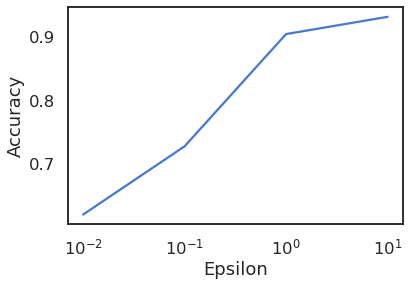

In [170]:
plt.plot(epsilons, accuracies)
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')